In [10]:
# TRFL

# pip install trfl tensorflow==1.12 tensorflow-probability==0.5 gym matplotlib

import trfl
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from collections import deque

train_episodes = 10000        # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [3]:
# Environment
env = gym.make('CartPole-v0')

In [4]:
# Agent
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, batch_size=20,
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [batch_size], name='actions')
            #one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            #self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            #Non trfl way from tutorial: https://github.com/udacity/deep-learning/blob/master/reinforcement/Q-learning-cart.ipynb
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
#             self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
#             self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
#             self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

            #TRFL way
            self.targetQs_ = tf.placeholder(tf.float32, [batch_size,action_size], name='target')
            self.reward = tf.placeholder(tf.float32,[batch_size],name="reward")
            self.discount = tf.constant(0.99,shape=[batch_size],dtype=tf.float32,name="discount")
      
            #TRFL qlearning
            qloss, q_learning = trfl.qlearning(self.output,self.actions_,self.reward,self.discount,self.targetQs_)
            self.loss = tf.reduce_mean(qloss)
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [5]:
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [6]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate,batch_size=batch_size)

In [7]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [11]:
# Training
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
      
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            #tutorial way
            #targets = rewards + gamma * np.max(target_Qs, axis=1)
#             loss, _ = sess.run([mainQN.loss, mainQN.opt],
#                                 feed_dict={mainQN.inputs_: states,
#                                            mainQN.targetQs_: targets,
#                                            mainQN.actions_: actions})

            #TRFL way, calculate td_error within TRFL
            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: target_Qs,
                                           mainQN.reward: rewards,
                                           mainQN.actions_: actions})
        
    #saver.save(sess, "checkpoints/cartpole.ckpt")
print("Training done!")

Episode: 1 Total reward: 9.0 Training loss: 0.5523 Explore P: 0.9991
Episode: 2 Total reward: 10.0 Training loss: 0.5705 Explore P: 0.9981
Episode: 3 Total reward: 8.0 Training loss: 0.5583 Explore P: 0.9973
Episode: 4 Total reward: 9.0 Training loss: 0.5288 Explore P: 0.9964
Episode: 5 Total reward: 13.0 Training loss: 0.5435 Explore P: 0.9952
Episode: 6 Total reward: 31.0 Training loss: 0.5284 Explore P: 0.9921
Episode: 7 Total reward: 37.0 Training loss: 0.5223 Explore P: 0.9885
Episode: 8 Total reward: 44.0 Training loss: 0.5346 Explore P: 0.9842
Episode: 9 Total reward: 55.0 Training loss: 0.4888 Explore P: 0.9788
Episode: 10 Total reward: 17.0 Training loss: 0.5215 Explore P: 0.9772
Episode: 11 Total reward: 14.0 Training loss: 0.5512 Explore P: 0.9758
Episode: 12 Total reward: 28.0 Training loss: 0.6235 Explore P: 0.9731
Episode: 13 Total reward: 25.0 Training loss: 0.5174 Explore P: 0.9707
Episode: 14 Total reward: 34.0 Training loss: 0.5873 Explore P: 0.9675
Episode: 15 Total 

Episode: 117 Total reward: 32.0 Training loss: 0.6241 Explore P: 0.7695
Episode: 118 Total reward: 41.0 Training loss: 0.4945 Explore P: 0.7664
Episode: 119 Total reward: 42.0 Training loss: 0.7854 Explore P: 0.7633
Episode: 120 Total reward: 14.0 Training loss: 0.5541 Explore P: 0.7622
Episode: 121 Total reward: 16.0 Training loss: 0.6103 Explore P: 0.7610
Episode: 122 Total reward: 19.0 Training loss: 0.9797 Explore P: 0.7596
Episode: 123 Total reward: 23.0 Training loss: 29.3027 Explore P: 0.7579
Episode: 124 Total reward: 31.0 Training loss: 0.8584 Explore P: 0.7555
Episode: 125 Total reward: 13.0 Training loss: 1.5066 Explore P: 0.7546
Episode: 126 Total reward: 19.0 Training loss: 0.5767 Explore P: 0.7532
Episode: 127 Total reward: 10.0 Training loss: 0.6137 Explore P: 0.7524
Episode: 128 Total reward: 19.0 Training loss: 40.6325 Explore P: 0.7510
Episode: 129 Total reward: 26.0 Training loss: 0.7858 Explore P: 0.7491
Episode: 130 Total reward: 15.0 Training loss: 0.5323 Explore 

Episode: 236 Total reward: 21.0 Training loss: 0.9968 Explore P: 0.5942
Episode: 237 Total reward: 21.0 Training loss: 0.4443 Explore P: 0.5930
Episode: 238 Total reward: 19.0 Training loss: 0.8197 Explore P: 0.5919
Episode: 239 Total reward: 13.0 Training loss: 31.2560 Explore P: 0.5911
Episode: 240 Total reward: 13.0 Training loss: 0.7063 Explore P: 0.5904
Episode: 241 Total reward: 13.0 Training loss: 45.2323 Explore P: 0.5896
Episode: 242 Total reward: 20.0 Training loss: 0.6907 Explore P: 0.5885
Episode: 243 Total reward: 17.0 Training loss: 67.9789 Explore P: 0.5875
Episode: 244 Total reward: 56.0 Training loss: 48.6463 Explore P: 0.5843
Episode: 245 Total reward: 32.0 Training loss: 104.5185 Explore P: 0.5824
Episode: 246 Total reward: 20.0 Training loss: 0.4791 Explore P: 0.5813
Episode: 247 Total reward: 31.0 Training loss: 0.6539 Explore P: 0.5795
Episode: 248 Total reward: 11.0 Training loss: 23.1843 Explore P: 0.5789
Episode: 249 Total reward: 17.0 Training loss: 0.5622 Exp

Episode: 349 Total reward: 27.0 Training loss: 39.6648 Explore P: 0.4534
Episode: 350 Total reward: 19.0 Training loss: 72.7213 Explore P: 0.4525
Episode: 351 Total reward: 32.0 Training loss: 21.7293 Explore P: 0.4511
Episode: 352 Total reward: 53.0 Training loss: 19.0868 Explore P: 0.4488
Episode: 353 Total reward: 84.0 Training loss: 0.5964 Explore P: 0.4451
Episode: 354 Total reward: 54.0 Training loss: 23.6827 Explore P: 0.4428
Episode: 355 Total reward: 62.0 Training loss: 21.4443 Explore P: 0.4401
Episode: 356 Total reward: 51.0 Training loss: 0.6619 Explore P: 0.4379
Episode: 357 Total reward: 32.0 Training loss: 14.8013 Explore P: 0.4365
Episode: 358 Total reward: 53.0 Training loss: 0.7258 Explore P: 0.4343
Episode: 359 Total reward: 76.0 Training loss: 0.6217 Explore P: 0.4311
Episode: 360 Total reward: 29.0 Training loss: 0.8687 Explore P: 0.4299
Episode: 361 Total reward: 31.0 Training loss: 10.9474 Explore P: 0.4286
Episode: 362 Total reward: 20.0 Training loss: 0.7515 Ex

Episode: 463 Total reward: 39.0 Training loss: 18.0200 Explore P: 0.2600
Episode: 464 Total reward: 51.0 Training loss: 36.0281 Explore P: 0.2588
Episode: 465 Total reward: 38.0 Training loss: 2.3294 Explore P: 0.2578
Episode: 466 Total reward: 27.0 Training loss: 1.7200 Explore P: 0.2572
Episode: 467 Total reward: 29.0 Training loss: 1.5401 Explore P: 0.2564
Episode: 468 Total reward: 27.0 Training loss: 5.6677 Explore P: 0.2558
Episode: 469 Total reward: 31.0 Training loss: 19.8303 Explore P: 0.2550
Episode: 470 Total reward: 21.0 Training loss: 1.4142 Explore P: 0.2545
Episode: 471 Total reward: 17.0 Training loss: 1.7879 Explore P: 0.2541
Episode: 472 Total reward: 31.0 Training loss: 1.7578 Explore P: 0.2533
Episode: 473 Total reward: 35.0 Training loss: 0.5490 Explore P: 0.2525
Episode: 474 Total reward: 40.0 Training loss: 21.8756 Explore P: 0.2515
Episode: 475 Total reward: 53.0 Training loss: 0.7752 Explore P: 0.2502
Episode: 476 Total reward: 39.0 Training loss: 18.5831 Explo

Episode: 576 Total reward: 117.0 Training loss: 34.9323 Explore P: 0.1144
Episode: 577 Total reward: 38.0 Training loss: 0.8908 Explore P: 0.1140
Episode: 578 Total reward: 37.0 Training loss: 17.3240 Explore P: 0.1136
Episode: 579 Total reward: 49.0 Training loss: 1.0967 Explore P: 0.1131
Episode: 580 Total reward: 39.0 Training loss: 21.9802 Explore P: 0.1127
Episode: 581 Total reward: 50.0 Training loss: 1.0716 Explore P: 0.1122
Episode: 582 Total reward: 93.0 Training loss: 14.5083 Explore P: 0.1113
Episode: 583 Total reward: 61.0 Training loss: 144.1695 Explore P: 0.1106
Episode: 584 Total reward: 29.0 Training loss: 0.8823 Explore P: 0.1103
Episode: 585 Total reward: 35.0 Training loss: 1.6908 Explore P: 0.1100
Episode: 586 Total reward: 69.0 Training loss: 320.7393 Explore P: 0.1093
Episode: 587 Total reward: 32.0 Training loss: 1.7707 Explore P: 0.1090
Episode: 588 Total reward: 26.0 Training loss: 1.3194 Explore P: 0.1087
Episode: 589 Total reward: 24.0 Training loss: 1.8320 E

Episode: 689 Total reward: 199.0 Training loss: 0.1423 Explore P: 0.0313
Episode: 690 Total reward: 199.0 Training loss: 0.1252 Explore P: 0.0309
Episode: 691 Total reward: 199.0 Training loss: 0.1926 Explore P: 0.0305
Episode: 692 Total reward: 199.0 Training loss: 0.2193 Explore P: 0.0301
Episode: 693 Total reward: 199.0 Training loss: 0.1298 Explore P: 0.0297
Episode: 694 Total reward: 199.0 Training loss: 0.1699 Explore P: 0.0293
Episode: 695 Total reward: 199.0 Training loss: 0.1003 Explore P: 0.0289
Episode: 696 Total reward: 199.0 Training loss: 0.1644 Explore P: 0.0285
Episode: 697 Total reward: 199.0 Training loss: 0.1688 Explore P: 0.0282
Episode: 698 Total reward: 199.0 Training loss: 0.1643 Explore P: 0.0278
Episode: 699 Total reward: 199.0 Training loss: 0.1526 Explore P: 0.0275
Episode: 700 Total reward: 199.0 Training loss: 0.2100 Explore P: 0.0271
Episode: 701 Total reward: 199.0 Training loss: 0.1732 Explore P: 0.0268
Episode: 702 Total reward: 199.0 Training loss: 0.2

Episode: 810 Total reward: 11.0 Training loss: 1.8847 Explore P: 0.0212
Episode: 811 Total reward: 12.0 Training loss: 1.5854 Explore P: 0.0212
Episode: 812 Total reward: 12.0 Training loss: 2.3265 Explore P: 0.0212
Episode: 813 Total reward: 10.0 Training loss: 0.7334 Explore P: 0.0212
Episode: 814 Total reward: 12.0 Training loss: 1.2022 Explore P: 0.0212
Episode: 815 Total reward: 11.0 Training loss: 670.5562 Explore P: 0.0211
Episode: 816 Total reward: 13.0 Training loss: 288.5582 Explore P: 0.0211
Episode: 817 Total reward: 12.0 Training loss: 1.8876 Explore P: 0.0211
Episode: 818 Total reward: 13.0 Training loss: 319.4330 Explore P: 0.0211
Episode: 819 Total reward: 10.0 Training loss: 3.3088 Explore P: 0.0211
Episode: 820 Total reward: 8.0 Training loss: 1.8226 Explore P: 0.0211
Episode: 821 Total reward: 10.0 Training loss: 1.9251 Explore P: 0.0211
Episode: 822 Total reward: 10.0 Training loss: 3.0817 Explore P: 0.0211
Episode: 823 Total reward: 11.0 Training loss: 1.5974 Explo

Episode: 928 Total reward: 11.0 Training loss: 10.2209 Explore P: 0.0145
Episode: 929 Total reward: 15.0 Training loss: 680.9965 Explore P: 0.0145
Episode: 930 Total reward: 15.0 Training loss: 616.8605 Explore P: 0.0145
Episode: 931 Total reward: 12.0 Training loss: 649.2800 Explore P: 0.0145
Episode: 932 Total reward: 12.0 Training loss: 17.5931 Explore P: 0.0145
Episode: 933 Total reward: 10.0 Training loss: 14.0408 Explore P: 0.0145
Episode: 934 Total reward: 16.0 Training loss: 13.1953 Explore P: 0.0145
Episode: 935 Total reward: 10.0 Training loss: 16.9779 Explore P: 0.0145
Episode: 936 Total reward: 12.0 Training loss: 12.9667 Explore P: 0.0145
Episode: 937 Total reward: 11.0 Training loss: 452.4288 Explore P: 0.0145
Episode: 938 Total reward: 15.0 Training loss: 9.3114 Explore P: 0.0145
Episode: 939 Total reward: 15.0 Training loss: 1922.1816 Explore P: 0.0145
Episode: 940 Total reward: 15.0 Training loss: 311.7955 Explore P: 0.0145
Episode: 941 Total reward: 14.0 Training loss

Episode: 1040 Total reward: 199.0 Training loss: 0.1190 Explore P: 0.0109
Episode: 1041 Total reward: 165.0 Training loss: 0.0616 Explore P: 0.0109
Episode: 1042 Total reward: 199.0 Training loss: 0.1145 Explore P: 0.0109
Episode: 1043 Total reward: 166.0 Training loss: 0.0423 Explore P: 0.0109
Episode: 1044 Total reward: 161.0 Training loss: 0.1084 Explore P: 0.0109
Episode: 1045 Total reward: 177.0 Training loss: 0.0563 Explore P: 0.0108
Episode: 1046 Total reward: 185.0 Training loss: 0.0785 Explore P: 0.0108
Episode: 1047 Total reward: 147.0 Training loss: 0.1669 Explore P: 0.0108
Episode: 1048 Total reward: 166.0 Training loss: 0.0618 Explore P: 0.0108
Episode: 1049 Total reward: 147.0 Training loss: 0.1299 Explore P: 0.0108
Episode: 1050 Total reward: 199.0 Training loss: 0.0853 Explore P: 0.0108
Episode: 1051 Total reward: 195.0 Training loss: 0.0571 Explore P: 0.0108
Episode: 1052 Total reward: 199.0 Training loss: 0.0879 Explore P: 0.0107
Episode: 1053 Total reward: 199.0 Trai

Episode: 1151 Total reward: 199.0 Training loss: 0.2202 Explore P: 0.0101
Episode: 1152 Total reward: 199.0 Training loss: 0.1908 Explore P: 0.0101
Episode: 1153 Total reward: 199.0 Training loss: 0.1669 Explore P: 0.0101
Episode: 1154 Total reward: 199.0 Training loss: 0.2562 Explore P: 0.0101
Episode: 1155 Total reward: 199.0 Training loss: 0.2900 Explore P: 0.0101
Episode: 1156 Total reward: 199.0 Training loss: 0.2374 Explore P: 0.0101
Episode: 1157 Total reward: 199.0 Training loss: 116.3864 Explore P: 0.0101
Episode: 1158 Total reward: 199.0 Training loss: 0.1454 Explore P: 0.0101
Episode: 1159 Total reward: 199.0 Training loss: 0.2503 Explore P: 0.0101
Episode: 1160 Total reward: 199.0 Training loss: 0.2603 Explore P: 0.0101
Episode: 1161 Total reward: 199.0 Training loss: 0.1959 Explore P: 0.0101
Episode: 1162 Total reward: 199.0 Training loss: 137.7820 Explore P: 0.0101
Episode: 1163 Total reward: 199.0 Training loss: 0.3586 Explore P: 0.0101
Episode: 1164 Total reward: 199.0 

Episode: 1262 Total reward: 199.0 Training loss: 0.4897 Explore P: 0.0100
Episode: 1263 Total reward: 199.0 Training loss: 0.9442 Explore P: 0.0100
Episode: 1264 Total reward: 199.0 Training loss: 1.1884 Explore P: 0.0100
Episode: 1265 Total reward: 199.0 Training loss: 1.8701 Explore P: 0.0100
Episode: 1266 Total reward: 199.0 Training loss: 2.1637 Explore P: 0.0100
Episode: 1267 Total reward: 199.0 Training loss: 1.2881 Explore P: 0.0100
Episode: 1268 Total reward: 184.0 Training loss: 3.1249 Explore P: 0.0100
Episode: 1269 Total reward: 165.0 Training loss: 3.5682 Explore P: 0.0100
Episode: 1270 Total reward: 155.0 Training loss: 149.8280 Explore P: 0.0100
Episode: 1271 Total reward: 162.0 Training loss: 3.2781 Explore P: 0.0100
Episode: 1272 Total reward: 199.0 Training loss: 3.3024 Explore P: 0.0100
Episode: 1273 Total reward: 196.0 Training loss: 2.5633 Explore P: 0.0100
Episode: 1274 Total reward: 186.0 Training loss: 2.7899 Explore P: 0.0100
Episode: 1275 Total reward: 193.0 Tr

Episode: 1373 Total reward: 199.0 Training loss: 0.1200 Explore P: 0.0100
Episode: 1374 Total reward: 198.0 Training loss: 59.8433 Explore P: 0.0100
Episode: 1375 Total reward: 199.0 Training loss: 0.1716 Explore P: 0.0100
Episode: 1376 Total reward: 199.0 Training loss: 0.1595 Explore P: 0.0100
Episode: 1377 Total reward: 199.0 Training loss: 0.1060 Explore P: 0.0100
Episode: 1378 Total reward: 199.0 Training loss: 0.0675 Explore P: 0.0100
Episode: 1379 Total reward: 184.0 Training loss: 0.0942 Explore P: 0.0100
Episode: 1380 Total reward: 196.0 Training loss: 0.2110 Explore P: 0.0100
Episode: 1381 Total reward: 158.0 Training loss: 78.3487 Explore P: 0.0100
Episode: 1382 Total reward: 181.0 Training loss: 0.0966 Explore P: 0.0100
Episode: 1383 Total reward: 199.0 Training loss: 0.1150 Explore P: 0.0100
Episode: 1384 Total reward: 176.0 Training loss: 137.5929 Explore P: 0.0100
Episode: 1385 Total reward: 186.0 Training loss: 0.1806 Explore P: 0.0100
Episode: 1386 Total reward: 178.0 

Episode: 1484 Total reward: 199.0 Training loss: 0.0412 Explore P: 0.0100
Episode: 1485 Total reward: 199.0 Training loss: 0.0446 Explore P: 0.0100
Episode: 1486 Total reward: 199.0 Training loss: 0.0905 Explore P: 0.0100
Episode: 1487 Total reward: 199.0 Training loss: 0.0630 Explore P: 0.0100
Episode: 1488 Total reward: 199.0 Training loss: 0.0283 Explore P: 0.0100
Episode: 1489 Total reward: 199.0 Training loss: 0.0112 Explore P: 0.0100
Episode: 1490 Total reward: 199.0 Training loss: 0.0777 Explore P: 0.0100
Episode: 1491 Total reward: 199.0 Training loss: 0.0285 Explore P: 0.0100
Episode: 1492 Total reward: 199.0 Training loss: 3.7852 Explore P: 0.0100
Episode: 1493 Total reward: 199.0 Training loss: 0.0383 Explore P: 0.0100
Episode: 1494 Total reward: 199.0 Training loss: 0.0384 Explore P: 0.0100
Episode: 1495 Total reward: 199.0 Training loss: 0.0216 Explore P: 0.0100
Episode: 1496 Total reward: 199.0 Training loss: 0.0310 Explore P: 0.0100
Episode: 1497 Total reward: 199.0 Trai

Episode: 1595 Total reward: 199.0 Training loss: 0.1304 Explore P: 0.0100
Episode: 1596 Total reward: 199.0 Training loss: 0.0651 Explore P: 0.0100
Episode: 1597 Total reward: 199.0 Training loss: 0.0289 Explore P: 0.0100
Episode: 1598 Total reward: 199.0 Training loss: 40.3617 Explore P: 0.0100
Episode: 1599 Total reward: 199.0 Training loss: 0.0235 Explore P: 0.0100
Episode: 1600 Total reward: 199.0 Training loss: 0.1341 Explore P: 0.0100
Episode: 1601 Total reward: 199.0 Training loss: 0.0899 Explore P: 0.0100
Episode: 1602 Total reward: 199.0 Training loss: 0.0302 Explore P: 0.0100
Episode: 1603 Total reward: 199.0 Training loss: 0.1091 Explore P: 0.0100
Episode: 1604 Total reward: 199.0 Training loss: 0.0321 Explore P: 0.0100
Episode: 1605 Total reward: 199.0 Training loss: 0.1200 Explore P: 0.0100
Episode: 1606 Total reward: 199.0 Training loss: 0.0568 Explore P: 0.0100
Episode: 1607 Total reward: 199.0 Training loss: 0.0449 Explore P: 0.0100
Episode: 1608 Total reward: 199.0 Tra

Episode: 1706 Total reward: 199.0 Training loss: 0.1259 Explore P: 0.0100
Episode: 1707 Total reward: 199.0 Training loss: 0.1580 Explore P: 0.0100
Episode: 1708 Total reward: 199.0 Training loss: 0.1052 Explore P: 0.0100
Episode: 1709 Total reward: 199.0 Training loss: 0.1506 Explore P: 0.0100
Episode: 1710 Total reward: 199.0 Training loss: 0.1201 Explore P: 0.0100
Episode: 1711 Total reward: 199.0 Training loss: 0.0981 Explore P: 0.0100
Episode: 1712 Total reward: 199.0 Training loss: 0.1557 Explore P: 0.0100
Episode: 1713 Total reward: 199.0 Training loss: 0.0656 Explore P: 0.0100
Episode: 1714 Total reward: 199.0 Training loss: 0.0899 Explore P: 0.0100
Episode: 1715 Total reward: 199.0 Training loss: 0.1522 Explore P: 0.0100
Episode: 1716 Total reward: 199.0 Training loss: 0.1134 Explore P: 0.0100
Episode: 1717 Total reward: 199.0 Training loss: 0.0585 Explore P: 0.0100
Episode: 1718 Total reward: 199.0 Training loss: 0.0853 Explore P: 0.0100
Episode: 1719 Total reward: 199.0 Trai

Episode: 1817 Total reward: 199.0 Training loss: 0.0827 Explore P: 0.0100
Episode: 1818 Total reward: 199.0 Training loss: 0.0665 Explore P: 0.0100
Episode: 1819 Total reward: 199.0 Training loss: 0.1507 Explore P: 0.0100
Episode: 1820 Total reward: 199.0 Training loss: 0.2564 Explore P: 0.0100
Episode: 1821 Total reward: 199.0 Training loss: 0.0822 Explore P: 0.0100
Episode: 1822 Total reward: 199.0 Training loss: 0.1198 Explore P: 0.0100
Episode: 1823 Total reward: 199.0 Training loss: 0.1215 Explore P: 0.0100
Episode: 1824 Total reward: 199.0 Training loss: 0.1053 Explore P: 0.0100
Episode: 1825 Total reward: 199.0 Training loss: 0.1444 Explore P: 0.0100
Episode: 1826 Total reward: 199.0 Training loss: 0.1929 Explore P: 0.0100
Episode: 1827 Total reward: 199.0 Training loss: 110.4335 Explore P: 0.0100
Episode: 1828 Total reward: 199.0 Training loss: 0.2034 Explore P: 0.0100
Episode: 1829 Total reward: 199.0 Training loss: 38.4917 Explore P: 0.0100
Episode: 1830 Total reward: 199.0 T

Episode: 1928 Total reward: 199.0 Training loss: 0.1720 Explore P: 0.0100
Episode: 1929 Total reward: 199.0 Training loss: 0.1556 Explore P: 0.0100
Episode: 1930 Total reward: 199.0 Training loss: 0.1269 Explore P: 0.0100
Episode: 1931 Total reward: 199.0 Training loss: 0.1259 Explore P: 0.0100
Episode: 1932 Total reward: 199.0 Training loss: 0.3389 Explore P: 0.0100
Episode: 1933 Total reward: 199.0 Training loss: 0.1464 Explore P: 0.0100
Episode: 1934 Total reward: 199.0 Training loss: 104.8261 Explore P: 0.0100
Episode: 1935 Total reward: 199.0 Training loss: 97.7038 Explore P: 0.0100
Episode: 1936 Total reward: 199.0 Training loss: 0.1121 Explore P: 0.0100
Episode: 1937 Total reward: 199.0 Training loss: 0.0595 Explore P: 0.0100
Episode: 1938 Total reward: 199.0 Training loss: 109.9197 Explore P: 0.0100
Episode: 1939 Total reward: 199.0 Training loss: 0.1627 Explore P: 0.0100
Episode: 1940 Total reward: 199.0 Training loss: 0.0929 Explore P: 0.0100
Episode: 1941 Total reward: 199.0

Episode: 2039 Total reward: 135.0 Training loss: 0.5026 Explore P: 0.0100
Episode: 2040 Total reward: 158.0 Training loss: 0.6656 Explore P: 0.0100
Episode: 2041 Total reward: 36.0 Training loss: 34.1173 Explore P: 0.0100
Episode: 2042 Total reward: 167.0 Training loss: 0.2019 Explore P: 0.0100
Episode: 2043 Total reward: 182.0 Training loss: 0.3185 Explore P: 0.0100
Episode: 2044 Total reward: 199.0 Training loss: 0.1610 Explore P: 0.0100
Episode: 2045 Total reward: 199.0 Training loss: 0.3419 Explore P: 0.0100
Episode: 2046 Total reward: 199.0 Training loss: 0.2964 Explore P: 0.0100
Episode: 2047 Total reward: 199.0 Training loss: 0.3387 Explore P: 0.0100
Episode: 2048 Total reward: 199.0 Training loss: 0.4595 Explore P: 0.0100
Episode: 2049 Total reward: 199.0 Training loss: 0.3787 Explore P: 0.0100
Episode: 2050 Total reward: 199.0 Training loss: 0.5647 Explore P: 0.0100
Episode: 2051 Total reward: 199.0 Training loss: 0.7303 Explore P: 0.0100
Episode: 2052 Total reward: 199.0 Trai

Episode: 2151 Total reward: 199.0 Training loss: 5.2290 Explore P: 0.0100
Episode: 2152 Total reward: 199.0 Training loss: 2.3193 Explore P: 0.0100
Episode: 2153 Total reward: 199.0 Training loss: 4.8950 Explore P: 0.0100
Episode: 2154 Total reward: 199.0 Training loss: 302.5203 Explore P: 0.0100
Episode: 2155 Total reward: 199.0 Training loss: 87.8153 Explore P: 0.0100
Episode: 2156 Total reward: 199.0 Training loss: 3.4561 Explore P: 0.0100
Episode: 2157 Total reward: 199.0 Training loss: 3.8080 Explore P: 0.0100
Episode: 2158 Total reward: 199.0 Training loss: 2.6288 Explore P: 0.0100
Episode: 2159 Total reward: 199.0 Training loss: 430.4253 Explore P: 0.0100
Episode: 2160 Total reward: 199.0 Training loss: 121.8463 Explore P: 0.0100
Episode: 2161 Total reward: 199.0 Training loss: 7.5603 Explore P: 0.0100
Episode: 2162 Total reward: 199.0 Training loss: 5.9430 Explore P: 0.0100
Episode: 2163 Total reward: 199.0 Training loss: 10.8084 Explore P: 0.0100
Episode: 2164 Total reward: 19

Episode: 2262 Total reward: 199.0 Training loss: 3.2294 Explore P: 0.0100
Episode: 2263 Total reward: 199.0 Training loss: 2.4211 Explore P: 0.0100
Episode: 2264 Total reward: 199.0 Training loss: 5.3349 Explore P: 0.0100
Episode: 2265 Total reward: 199.0 Training loss: 11.5837 Explore P: 0.0100
Episode: 2266 Total reward: 148.0 Training loss: 877.9054 Explore P: 0.0100
Episode: 2267 Total reward: 99.0 Training loss: 16.5811 Explore P: 0.0100
Episode: 2268 Total reward: 21.0 Training loss: 39.1058 Explore P: 0.0100
Episode: 2269 Total reward: 14.0 Training loss: 23.4434 Explore P: 0.0100
Episode: 2270 Total reward: 15.0 Training loss: 28.9506 Explore P: 0.0100
Episode: 2271 Total reward: 12.0 Training loss: 25.9241 Explore P: 0.0100
Episode: 2272 Total reward: 14.0 Training loss: 36.8698 Explore P: 0.0100
Episode: 2273 Total reward: 14.0 Training loss: 38.1692 Explore P: 0.0100
Episode: 2274 Total reward: 15.0 Training loss: 35.2768 Explore P: 0.0100
Episode: 2275 Total reward: 10.0 Tr

Episode: 2372 Total reward: 199.0 Training loss: 677.5369 Explore P: 0.0100
Episode: 2373 Total reward: 199.0 Training loss: 1310.5886 Explore P: 0.0100
Episode: 2374 Total reward: 199.0 Training loss: 17.4742 Explore P: 0.0100
Episode: 2375 Total reward: 199.0 Training loss: 13.5869 Explore P: 0.0100
Episode: 2376 Total reward: 199.0 Training loss: 32.0303 Explore P: 0.0100
Episode: 2377 Total reward: 199.0 Training loss: 18.1834 Explore P: 0.0100
Episode: 2378 Total reward: 199.0 Training loss: 25.0263 Explore P: 0.0100
Episode: 2379 Total reward: 199.0 Training loss: 16.0612 Explore P: 0.0100
Episode: 2380 Total reward: 199.0 Training loss: 388.4585 Explore P: 0.0100
Episode: 2381 Total reward: 199.0 Training loss: 17.3900 Explore P: 0.0100
Episode: 2382 Total reward: 199.0 Training loss: 14.7084 Explore P: 0.0100
Episode: 2383 Total reward: 199.0 Training loss: 13.1918 Explore P: 0.0100
Episode: 2384 Total reward: 199.0 Training loss: 16.5899 Explore P: 0.0100
Episode: 2385 Total r

Episode: 2483 Total reward: 174.0 Training loss: 0.6445 Explore P: 0.0100
Episode: 2484 Total reward: 187.0 Training loss: 0.2416 Explore P: 0.0100
Episode: 2485 Total reward: 196.0 Training loss: 0.3090 Explore P: 0.0100
Episode: 2486 Total reward: 179.0 Training loss: 0.5248 Explore P: 0.0100
Episode: 2487 Total reward: 182.0 Training loss: 0.2630 Explore P: 0.0100
Episode: 2488 Total reward: 199.0 Training loss: 1.3329 Explore P: 0.0100
Episode: 2489 Total reward: 184.0 Training loss: 0.2923 Explore P: 0.0100
Episode: 2490 Total reward: 169.0 Training loss: 0.3854 Explore P: 0.0100
Episode: 2491 Total reward: 174.0 Training loss: 0.3587 Explore P: 0.0100
Episode: 2492 Total reward: 182.0 Training loss: 5.0153 Explore P: 0.0100
Episode: 2493 Total reward: 180.0 Training loss: 0.2966 Explore P: 0.0100
Episode: 2494 Total reward: 171.0 Training loss: 0.2566 Explore P: 0.0100
Episode: 2495 Total reward: 151.0 Training loss: 0.2852 Explore P: 0.0100
Episode: 2496 Total reward: 147.0 Trai

Episode: 2594 Total reward: 154.0 Training loss: 0.0870 Explore P: 0.0100
Episode: 2595 Total reward: 182.0 Training loss: 0.3141 Explore P: 0.0100
Episode: 2596 Total reward: 199.0 Training loss: 0.0644 Explore P: 0.0100
Episode: 2597 Total reward: 199.0 Training loss: 0.1088 Explore P: 0.0100
Episode: 2598 Total reward: 149.0 Training loss: 0.1169 Explore P: 0.0100
Episode: 2599 Total reward: 199.0 Training loss: 0.1659 Explore P: 0.0100
Episode: 2600 Total reward: 172.0 Training loss: 0.1347 Explore P: 0.0100
Episode: 2601 Total reward: 123.0 Training loss: 0.0583 Explore P: 0.0100
Episode: 2602 Total reward: 156.0 Training loss: 0.2454 Explore P: 0.0100
Episode: 2603 Total reward: 199.0 Training loss: 0.0573 Explore P: 0.0100
Episode: 2604 Total reward: 199.0 Training loss: 0.0414 Explore P: 0.0100
Episode: 2605 Total reward: 141.0 Training loss: 0.2096 Explore P: 0.0100
Episode: 2606 Total reward: 128.0 Training loss: 0.3558 Explore P: 0.0100
Episode: 2607 Total reward: 199.0 Trai

Episode: 2705 Total reward: 199.0 Training loss: 0.0608 Explore P: 0.0100
Episode: 2706 Total reward: 199.0 Training loss: 0.0410 Explore P: 0.0100
Episode: 2707 Total reward: 160.0 Training loss: 0.0368 Explore P: 0.0100
Episode: 2708 Total reward: 128.0 Training loss: 0.1059 Explore P: 0.0100
Episode: 2709 Total reward: 182.0 Training loss: 0.0707 Explore P: 0.0100
Episode: 2710 Total reward: 199.0 Training loss: 0.0726 Explore P: 0.0100
Episode: 2711 Total reward: 160.0 Training loss: 0.0521 Explore P: 0.0100
Episode: 2712 Total reward: 199.0 Training loss: 0.0234 Explore P: 0.0100
Episode: 2713 Total reward: 134.0 Training loss: 0.3861 Explore P: 0.0100
Episode: 2714 Total reward: 199.0 Training loss: 0.0608 Explore P: 0.0100
Episode: 2715 Total reward: 199.0 Training loss: 0.0476 Explore P: 0.0100
Episode: 2716 Total reward: 188.0 Training loss: 0.0597 Explore P: 0.0100
Episode: 2717 Total reward: 199.0 Training loss: 0.0170 Explore P: 0.0100
Episode: 2718 Total reward: 199.0 Trai

Episode: 2816 Total reward: 199.0 Training loss: 0.0532 Explore P: 0.0100
Episode: 2817 Total reward: 199.0 Training loss: 0.0954 Explore P: 0.0100
Episode: 2818 Total reward: 142.0 Training loss: 0.0430 Explore P: 0.0100
Episode: 2819 Total reward: 191.0 Training loss: 0.0609 Explore P: 0.0100
Episode: 2820 Total reward: 199.0 Training loss: 0.0395 Explore P: 0.0100
Episode: 2821 Total reward: 183.0 Training loss: 0.0699 Explore P: 0.0100
Episode: 2822 Total reward: 199.0 Training loss: 0.0435 Explore P: 0.0100
Episode: 2823 Total reward: 199.0 Training loss: 0.0416 Explore P: 0.0100
Episode: 2824 Total reward: 154.0 Training loss: 0.0195 Explore P: 0.0100
Episode: 2825 Total reward: 163.0 Training loss: 0.0267 Explore P: 0.0100
Episode: 2826 Total reward: 199.0 Training loss: 110.4473 Explore P: 0.0100
Episode: 2827 Total reward: 199.0 Training loss: 0.0722 Explore P: 0.0100
Episode: 2828 Total reward: 199.0 Training loss: 0.0269 Explore P: 0.0100
Episode: 2829 Total reward: 188.0 Tr

Episode: 2927 Total reward: 199.0 Training loss: 0.1070 Explore P: 0.0100
Episode: 2928 Total reward: 199.0 Training loss: 0.1049 Explore P: 0.0100
Episode: 2929 Total reward: 199.0 Training loss: 0.1037 Explore P: 0.0100
Episode: 2930 Total reward: 199.0 Training loss: 0.1887 Explore P: 0.0100
Episode: 2931 Total reward: 199.0 Training loss: 0.1336 Explore P: 0.0100
Episode: 2932 Total reward: 199.0 Training loss: 0.1021 Explore P: 0.0100
Episode: 2933 Total reward: 199.0 Training loss: 0.0440 Explore P: 0.0100
Episode: 2934 Total reward: 199.0 Training loss: 0.1317 Explore P: 0.0100
Episode: 2935 Total reward: 199.0 Training loss: 0.1265 Explore P: 0.0100
Episode: 2936 Total reward: 199.0 Training loss: 0.1294 Explore P: 0.0100
Episode: 2937 Total reward: 199.0 Training loss: 2.1774 Explore P: 0.0100
Episode: 2938 Total reward: 199.0 Training loss: 0.2356 Explore P: 0.0100
Episode: 2939 Total reward: 199.0 Training loss: 0.1373 Explore P: 0.0100
Episode: 2940 Total reward: 199.0 Trai

Episode: 3045 Total reward: 10.0 Training loss: 6.1910 Explore P: 0.0100
Episode: 3046 Total reward: 11.0 Training loss: 3.3739 Explore P: 0.0100
Episode: 3047 Total reward: 9.0 Training loss: 4.8672 Explore P: 0.0100
Episode: 3048 Total reward: 8.0 Training loss: 5.3410 Explore P: 0.0100
Episode: 3049 Total reward: 8.0 Training loss: 4.0459 Explore P: 0.0100
Episode: 3050 Total reward: 10.0 Training loss: 5.0300 Explore P: 0.0100
Episode: 3051 Total reward: 12.0 Training loss: 5.1181 Explore P: 0.0100
Episode: 3052 Total reward: 9.0 Training loss: 877.0355 Explore P: 0.0100
Episode: 3053 Total reward: 10.0 Training loss: 5.2171 Explore P: 0.0100
Episode: 3054 Total reward: 11.0 Training loss: 4.6881 Explore P: 0.0100
Episode: 3055 Total reward: 9.0 Training loss: 809.8679 Explore P: 0.0100
Episode: 3056 Total reward: 11.0 Training loss: 6.4696 Explore P: 0.0100
Episode: 3057 Total reward: 11.0 Training loss: 2.8993 Explore P: 0.0100
Episode: 3058 Total reward: 12.0 Training loss: 3.20

Episode: 3157 Total reward: 199.0 Training loss: 1.5749 Explore P: 0.0100
Episode: 3158 Total reward: 139.0 Training loss: 77.4662 Explore P: 0.0100
Episode: 3159 Total reward: 173.0 Training loss: 1.2051 Explore P: 0.0100
Episode: 3160 Total reward: 199.0 Training loss: 2.7292 Explore P: 0.0100
Episode: 3161 Total reward: 141.0 Training loss: 1.5796 Explore P: 0.0100
Episode: 3162 Total reward: 137.0 Training loss: 2.6864 Explore P: 0.0100
Episode: 3163 Total reward: 180.0 Training loss: 1.5356 Explore P: 0.0100
Episode: 3164 Total reward: 199.0 Training loss: 14.8176 Explore P: 0.0100
Episode: 3165 Total reward: 116.0 Training loss: 0.8848 Explore P: 0.0100
Episode: 3166 Total reward: 186.0 Training loss: 3.6261 Explore P: 0.0100
Episode: 3167 Total reward: 181.0 Training loss: 78.9979 Explore P: 0.0100
Episode: 3168 Total reward: 181.0 Training loss: 1.7150 Explore P: 0.0100
Episode: 3169 Total reward: 199.0 Training loss: 3.0236 Explore P: 0.0100
Episode: 3170 Total reward: 199.0 T

Episode: 3268 Total reward: 199.0 Training loss: 0.0585 Explore P: 0.0100
Episode: 3269 Total reward: 199.0 Training loss: 0.1436 Explore P: 0.0100
Episode: 3270 Total reward: 199.0 Training loss: 0.2461 Explore P: 0.0100
Episode: 3271 Total reward: 199.0 Training loss: 0.0797 Explore P: 0.0100
Episode: 3272 Total reward: 199.0 Training loss: 0.1066 Explore P: 0.0100
Episode: 3273 Total reward: 199.0 Training loss: 0.0285 Explore P: 0.0100
Episode: 3274 Total reward: 199.0 Training loss: 0.0673 Explore P: 0.0100
Episode: 3275 Total reward: 199.0 Training loss: 0.0423 Explore P: 0.0100
Episode: 3276 Total reward: 199.0 Training loss: 0.2083 Explore P: 0.0100
Episode: 3277 Total reward: 199.0 Training loss: 0.1631 Explore P: 0.0100
Episode: 3278 Total reward: 199.0 Training loss: 0.0751 Explore P: 0.0100
Episode: 3279 Total reward: 134.0 Training loss: 0.0890 Explore P: 0.0100
Episode: 3280 Total reward: 199.0 Training loss: 0.0697 Explore P: 0.0100
Episode: 3281 Total reward: 178.0 Trai

Episode: 3379 Total reward: 199.0 Training loss: 0.0651 Explore P: 0.0100
Episode: 3380 Total reward: 199.0 Training loss: 0.1409 Explore P: 0.0100
Episode: 3381 Total reward: 199.0 Training loss: 0.1528 Explore P: 0.0100
Episode: 3382 Total reward: 199.0 Training loss: 0.0511 Explore P: 0.0100
Episode: 3383 Total reward: 199.0 Training loss: 0.1400 Explore P: 0.0100
Episode: 3384 Total reward: 199.0 Training loss: 0.1451 Explore P: 0.0100
Episode: 3385 Total reward: 199.0 Training loss: 0.0848 Explore P: 0.0100
Episode: 3386 Total reward: 199.0 Training loss: 0.1236 Explore P: 0.0100
Episode: 3387 Total reward: 199.0 Training loss: 0.0687 Explore P: 0.0100
Episode: 3388 Total reward: 199.0 Training loss: 0.0958 Explore P: 0.0100
Episode: 3389 Total reward: 199.0 Training loss: 0.0671 Explore P: 0.0100
Episode: 3390 Total reward: 199.0 Training loss: 0.0780 Explore P: 0.0100
Episode: 3391 Total reward: 199.0 Training loss: 0.0800 Explore P: 0.0100
Episode: 3392 Total reward: 199.0 Trai

Episode: 3490 Total reward: 199.0 Training loss: 0.1654 Explore P: 0.0100
Episode: 3491 Total reward: 199.0 Training loss: 0.3729 Explore P: 0.0100
Episode: 3492 Total reward: 199.0 Training loss: 0.1312 Explore P: 0.0100
Episode: 3493 Total reward: 199.0 Training loss: 0.1025 Explore P: 0.0100
Episode: 3494 Total reward: 199.0 Training loss: 0.2275 Explore P: 0.0100
Episode: 3495 Total reward: 199.0 Training loss: 0.1022 Explore P: 0.0100
Episode: 3496 Total reward: 199.0 Training loss: 0.1091 Explore P: 0.0100
Episode: 3497 Total reward: 199.0 Training loss: 0.1137 Explore P: 0.0100
Episode: 3498 Total reward: 199.0 Training loss: 0.2012 Explore P: 0.0100
Episode: 3499 Total reward: 199.0 Training loss: 0.1001 Explore P: 0.0100
Episode: 3500 Total reward: 199.0 Training loss: 0.1760 Explore P: 0.0100
Episode: 3501 Total reward: 199.0 Training loss: 0.0968 Explore P: 0.0100
Episode: 3502 Total reward: 199.0 Training loss: 0.1088 Explore P: 0.0100
Episode: 3503 Total reward: 199.0 Trai

Episode: 3601 Total reward: 199.0 Training loss: 0.0971 Explore P: 0.0100
Episode: 3602 Total reward: 199.0 Training loss: 0.1183 Explore P: 0.0100
Episode: 3603 Total reward: 199.0 Training loss: 0.1204 Explore P: 0.0100
Episode: 3604 Total reward: 199.0 Training loss: 123.1501 Explore P: 0.0100
Episode: 3605 Total reward: 199.0 Training loss: 0.0692 Explore P: 0.0100
Episode: 3606 Total reward: 199.0 Training loss: 0.1068 Explore P: 0.0100
Episode: 3607 Total reward: 199.0 Training loss: 0.1655 Explore P: 0.0100
Episode: 3608 Total reward: 199.0 Training loss: 0.1178 Explore P: 0.0100
Episode: 3609 Total reward: 199.0 Training loss: 0.0576 Explore P: 0.0100
Episode: 3610 Total reward: 199.0 Training loss: 0.0776 Explore P: 0.0100
Episode: 3611 Total reward: 199.0 Training loss: 0.0853 Explore P: 0.0100
Episode: 3612 Total reward: 199.0 Training loss: 14.2130 Explore P: 0.0100
Episode: 3613 Total reward: 199.0 Training loss: 0.1129 Explore P: 0.0100
Episode: 3614 Total reward: 199.0 T

Episode: 3712 Total reward: 199.0 Training loss: 0.0525 Explore P: 0.0100
Episode: 3713 Total reward: 199.0 Training loss: 0.1606 Explore P: 0.0100
Episode: 3714 Total reward: 199.0 Training loss: 0.1994 Explore P: 0.0100
Episode: 3715 Total reward: 199.0 Training loss: 0.3781 Explore P: 0.0100
Episode: 3716 Total reward: 199.0 Training loss: 0.2091 Explore P: 0.0100
Episode: 3717 Total reward: 199.0 Training loss: 0.1308 Explore P: 0.0100
Episode: 3718 Total reward: 199.0 Training loss: 36.6877 Explore P: 0.0100
Episode: 3719 Total reward: 199.0 Training loss: 0.0901 Explore P: 0.0100
Episode: 3720 Total reward: 199.0 Training loss: 0.1238 Explore P: 0.0100
Episode: 3721 Total reward: 199.0 Training loss: 0.1533 Explore P: 0.0100
Episode: 3722 Total reward: 199.0 Training loss: 0.0413 Explore P: 0.0100
Episode: 3723 Total reward: 199.0 Training loss: 0.0727 Explore P: 0.0100
Episode: 3724 Total reward: 199.0 Training loss: 0.0990 Explore P: 0.0100
Episode: 3725 Total reward: 199.0 Tra

Episode: 3823 Total reward: 199.0 Training loss: 0.1338 Explore P: 0.0100
Episode: 3824 Total reward: 199.0 Training loss: 0.0361 Explore P: 0.0100
Episode: 3825 Total reward: 199.0 Training loss: 0.1330 Explore P: 0.0100
Episode: 3826 Total reward: 199.0 Training loss: 0.0811 Explore P: 0.0100
Episode: 3827 Total reward: 199.0 Training loss: 0.0874 Explore P: 0.0100
Episode: 3828 Total reward: 199.0 Training loss: 0.1091 Explore P: 0.0100
Episode: 3829 Total reward: 199.0 Training loss: 0.0884 Explore P: 0.0100
Episode: 3830 Total reward: 199.0 Training loss: 0.1483 Explore P: 0.0100
Episode: 3831 Total reward: 199.0 Training loss: 0.1269 Explore P: 0.0100
Episode: 3832 Total reward: 199.0 Training loss: 0.1414 Explore P: 0.0100
Episode: 3833 Total reward: 199.0 Training loss: 0.0998 Explore P: 0.0100
Episode: 3834 Total reward: 199.0 Training loss: 0.1305 Explore P: 0.0100
Episode: 3835 Total reward: 199.0 Training loss: 113.5313 Explore P: 0.0100
Episode: 3836 Total reward: 199.0 Tr

Episode: 3934 Total reward: 199.0 Training loss: 0.0811 Explore P: 0.0100
Episode: 3935 Total reward: 199.0 Training loss: 0.0686 Explore P: 0.0100
Episode: 3936 Total reward: 199.0 Training loss: 8.0591 Explore P: 0.0100
Episode: 3937 Total reward: 199.0 Training loss: 0.0828 Explore P: 0.0100
Episode: 3938 Total reward: 199.0 Training loss: 0.1000 Explore P: 0.0100
Episode: 3939 Total reward: 199.0 Training loss: 0.0622 Explore P: 0.0100
Episode: 3940 Total reward: 199.0 Training loss: 0.1003 Explore P: 0.0100
Episode: 3941 Total reward: 199.0 Training loss: 0.1854 Explore P: 0.0100
Episode: 3942 Total reward: 199.0 Training loss: 0.0585 Explore P: 0.0100
Episode: 3943 Total reward: 199.0 Training loss: 0.0862 Explore P: 0.0100
Episode: 3944 Total reward: 199.0 Training loss: 0.1063 Explore P: 0.0100
Episode: 3945 Total reward: 199.0 Training loss: 0.0870 Explore P: 0.0100
Episode: 3946 Total reward: 199.0 Training loss: 0.1138 Explore P: 0.0100
Episode: 3947 Total reward: 199.0 Trai

Episode: 4045 Total reward: 199.0 Training loss: 0.0913 Explore P: 0.0100
Episode: 4046 Total reward: 199.0 Training loss: 0.1462 Explore P: 0.0100
Episode: 4047 Total reward: 199.0 Training loss: 0.0574 Explore P: 0.0100
Episode: 4048 Total reward: 199.0 Training loss: 0.2612 Explore P: 0.0100
Episode: 4049 Total reward: 199.0 Training loss: 0.1308 Explore P: 0.0100
Episode: 4050 Total reward: 199.0 Training loss: 0.0882 Explore P: 0.0100
Episode: 4051 Total reward: 174.0 Training loss: 0.0611 Explore P: 0.0100
Episode: 4052 Total reward: 199.0 Training loss: 0.0488 Explore P: 0.0100
Episode: 4053 Total reward: 199.0 Training loss: 125.6037 Explore P: 0.0100
Episode: 4054 Total reward: 199.0 Training loss: 0.1513 Explore P: 0.0100
Episode: 4055 Total reward: 199.0 Training loss: 0.1290 Explore P: 0.0100
Episode: 4056 Total reward: 199.0 Training loss: 44.4601 Explore P: 0.0100
Episode: 4057 Total reward: 199.0 Training loss: 0.0920 Explore P: 0.0100
Episode: 4058 Total reward: 199.0 T

Episode: 4156 Total reward: 199.0 Training loss: 0.0886 Explore P: 0.0100
Episode: 4157 Total reward: 199.0 Training loss: 0.0594 Explore P: 0.0100
Episode: 4158 Total reward: 199.0 Training loss: 0.1291 Explore P: 0.0100
Episode: 4159 Total reward: 199.0 Training loss: 0.1287 Explore P: 0.0100
Episode: 4160 Total reward: 199.0 Training loss: 0.1174 Explore P: 0.0100
Episode: 4161 Total reward: 199.0 Training loss: 0.0414 Explore P: 0.0100
Episode: 4162 Total reward: 199.0 Training loss: 0.1704 Explore P: 0.0100
Episode: 4163 Total reward: 199.0 Training loss: 0.0782 Explore P: 0.0100
Episode: 4164 Total reward: 199.0 Training loss: 0.1498 Explore P: 0.0100
Episode: 4165 Total reward: 199.0 Training loss: 72.6540 Explore P: 0.0100
Episode: 4166 Total reward: 199.0 Training loss: 7.7963 Explore P: 0.0100
Episode: 4167 Total reward: 199.0 Training loss: 0.0525 Explore P: 0.0100
Episode: 4168 Total reward: 199.0 Training loss: 0.0577 Explore P: 0.0100
Episode: 4169 Total reward: 199.0 Tra

Episode: 4267 Total reward: 199.0 Training loss: 11.7368 Explore P: 0.0100
Episode: 4268 Total reward: 199.0 Training loss: 0.0058 Explore P: 0.0100
Episode: 4269 Total reward: 199.0 Training loss: 0.0135 Explore P: 0.0100
Episode: 4270 Total reward: 193.0 Training loss: 0.0101 Explore P: 0.0100
Episode: 4271 Total reward: 199.0 Training loss: 0.0219 Explore P: 0.0100
Episode: 4272 Total reward: 199.0 Training loss: 1.1188 Explore P: 0.0100
Episode: 4273 Total reward: 199.0 Training loss: 0.0282 Explore P: 0.0100
Episode: 4274 Total reward: 199.0 Training loss: 0.0753 Explore P: 0.0100
Episode: 4275 Total reward: 199.0 Training loss: 0.0180 Explore P: 0.0100
Episode: 4276 Total reward: 199.0 Training loss: 0.0353 Explore P: 0.0100
Episode: 4277 Total reward: 199.0 Training loss: 0.0228 Explore P: 0.0100
Episode: 4278 Total reward: 189.0 Training loss: 0.2364 Explore P: 0.0100
Episode: 4279 Total reward: 157.0 Training loss: 0.0254 Explore P: 0.0100
Episode: 4280 Total reward: 199.0 Tra

Episode: 4378 Total reward: 197.0 Training loss: 0.0251 Explore P: 0.0100
Episode: 4379 Total reward: 196.0 Training loss: 3.7397 Explore P: 0.0100
Episode: 4380 Total reward: 199.0 Training loss: 0.0638 Explore P: 0.0100
Episode: 4381 Total reward: 199.0 Training loss: 18.8860 Explore P: 0.0100
Episode: 4382 Total reward: 199.0 Training loss: 0.0601 Explore P: 0.0100
Episode: 4383 Total reward: 199.0 Training loss: 0.0380 Explore P: 0.0100
Episode: 4384 Total reward: 199.0 Training loss: 0.0384 Explore P: 0.0100
Episode: 4385 Total reward: 199.0 Training loss: 0.0513 Explore P: 0.0100
Episode: 4386 Total reward: 199.0 Training loss: 0.0493 Explore P: 0.0100
Episode: 4387 Total reward: 162.0 Training loss: 0.1444 Explore P: 0.0100
Episode: 4388 Total reward: 199.0 Training loss: 0.0751 Explore P: 0.0100
Episode: 4389 Total reward: 199.0 Training loss: 0.0827 Explore P: 0.0100
Episode: 4390 Total reward: 170.0 Training loss: 0.0445 Explore P: 0.0100
Episode: 4391 Total reward: 199.0 Tra

Episode: 4489 Total reward: 142.0 Training loss: 0.0918 Explore P: 0.0100
Episode: 4490 Total reward: 144.0 Training loss: 0.0617 Explore P: 0.0100
Episode: 4491 Total reward: 161.0 Training loss: 0.0739 Explore P: 0.0100
Episode: 4492 Total reward: 199.0 Training loss: 0.0644 Explore P: 0.0100
Episode: 4493 Total reward: 122.0 Training loss: 7.8460 Explore P: 0.0100
Episode: 4494 Total reward: 140.0 Training loss: 0.1070 Explore P: 0.0100
Episode: 4495 Total reward: 129.0 Training loss: 0.0625 Explore P: 0.0100
Episode: 4496 Total reward: 165.0 Training loss: 0.1203 Explore P: 0.0100
Episode: 4497 Total reward: 129.0 Training loss: 0.4830 Explore P: 0.0100
Episode: 4498 Total reward: 163.0 Training loss: 0.0842 Explore P: 0.0100
Episode: 4499 Total reward: 177.0 Training loss: 0.0733 Explore P: 0.0100
Episode: 4500 Total reward: 198.0 Training loss: 0.0993 Explore P: 0.0100
Episode: 4501 Total reward: 179.0 Training loss: 0.0629 Explore P: 0.0100
Episode: 4502 Total reward: 199.0 Trai

Episode: 4600 Total reward: 199.0 Training loss: 0.0860 Explore P: 0.0100
Episode: 4601 Total reward: 142.0 Training loss: 0.0696 Explore P: 0.0100
Episode: 4602 Total reward: 199.0 Training loss: 0.0751 Explore P: 0.0100
Episode: 4603 Total reward: 197.0 Training loss: 0.0892 Explore P: 0.0100
Episode: 4604 Total reward: 191.0 Training loss: 0.0825 Explore P: 0.0100
Episode: 4605 Total reward: 199.0 Training loss: 0.0975 Explore P: 0.0100
Episode: 4606 Total reward: 199.0 Training loss: 0.0936 Explore P: 0.0100
Episode: 4607 Total reward: 199.0 Training loss: 0.0230 Explore P: 0.0100
Episode: 4608 Total reward: 191.0 Training loss: 0.0352 Explore P: 0.0100
Episode: 4609 Total reward: 199.0 Training loss: 0.0782 Explore P: 0.0100
Episode: 4610 Total reward: 199.0 Training loss: 6.7648 Explore P: 0.0100
Episode: 4611 Total reward: 199.0 Training loss: 0.0768 Explore P: 0.0100
Episode: 4612 Total reward: 199.0 Training loss: 0.0306 Explore P: 0.0100
Episode: 4613 Total reward: 177.0 Trai

Episode: 4711 Total reward: 199.0 Training loss: 0.0764 Explore P: 0.0100
Episode: 4712 Total reward: 199.0 Training loss: 0.3287 Explore P: 0.0100
Episode: 4713 Total reward: 199.0 Training loss: 0.0895 Explore P: 0.0100
Episode: 4714 Total reward: 199.0 Training loss: 0.0639 Explore P: 0.0100
Episode: 4715 Total reward: 199.0 Training loss: 0.0492 Explore P: 0.0100
Episode: 4716 Total reward: 199.0 Training loss: 0.0967 Explore P: 0.0100
Episode: 4717 Total reward: 199.0 Training loss: 0.0737 Explore P: 0.0100
Episode: 4718 Total reward: 199.0 Training loss: 105.9216 Explore P: 0.0100
Episode: 4719 Total reward: 193.0 Training loss: 0.0530 Explore P: 0.0100
Episode: 4720 Total reward: 199.0 Training loss: 0.1071 Explore P: 0.0100
Episode: 4721 Total reward: 199.0 Training loss: 0.0528 Explore P: 0.0100
Episode: 4722 Total reward: 199.0 Training loss: 0.0368 Explore P: 0.0100
Episode: 4723 Total reward: 199.0 Training loss: 0.1068 Explore P: 0.0100
Episode: 4724 Total reward: 199.0 Tr

Episode: 4822 Total reward: 191.0 Training loss: 0.0778 Explore P: 0.0100
Episode: 4823 Total reward: 194.0 Training loss: 0.0482 Explore P: 0.0100
Episode: 4824 Total reward: 172.0 Training loss: 0.5194 Explore P: 0.0100
Episode: 4825 Total reward: 163.0 Training loss: 0.0238 Explore P: 0.0100
Episode: 4826 Total reward: 146.0 Training loss: 0.0357 Explore P: 0.0100
Episode: 4827 Total reward: 199.0 Training loss: 0.0495 Explore P: 0.0100
Episode: 4828 Total reward: 184.0 Training loss: 0.0267 Explore P: 0.0100
Episode: 4829 Total reward: 188.0 Training loss: 0.0322 Explore P: 0.0100
Episode: 4830 Total reward: 189.0 Training loss: 0.0270 Explore P: 0.0100
Episode: 4831 Total reward: 199.0 Training loss: 0.5352 Explore P: 0.0100
Episode: 4832 Total reward: 181.0 Training loss: 0.0519 Explore P: 0.0100
Episode: 4833 Total reward: 184.0 Training loss: 0.0246 Explore P: 0.0100
Episode: 4834 Total reward: 173.0 Training loss: 0.0206 Explore P: 0.0100
Episode: 4835 Total reward: 187.0 Trai

Episode: 4933 Total reward: 199.0 Training loss: 0.0581 Explore P: 0.0100
Episode: 4934 Total reward: 199.0 Training loss: 21.8400 Explore P: 0.0100
Episode: 4935 Total reward: 199.0 Training loss: 0.0310 Explore P: 0.0100
Episode: 4936 Total reward: 199.0 Training loss: 0.1480 Explore P: 0.0100
Episode: 4937 Total reward: 199.0 Training loss: 0.0497 Explore P: 0.0100
Episode: 4938 Total reward: 199.0 Training loss: 0.0829 Explore P: 0.0100
Episode: 4939 Total reward: 199.0 Training loss: 0.0671 Explore P: 0.0100
Episode: 4940 Total reward: 199.0 Training loss: 0.0293 Explore P: 0.0100
Episode: 4941 Total reward: 190.0 Training loss: 0.0988 Explore P: 0.0100
Episode: 4942 Total reward: 199.0 Training loss: 158.5980 Explore P: 0.0100
Episode: 4943 Total reward: 199.0 Training loss: 0.0550 Explore P: 0.0100
Episode: 4944 Total reward: 199.0 Training loss: 0.0424 Explore P: 0.0100
Episode: 4945 Total reward: 199.0 Training loss: 182.8750 Explore P: 0.0100
Episode: 4946 Total reward: 199.0

Episode: 5044 Total reward: 199.0 Training loss: 0.0675 Explore P: 0.0100
Episode: 5045 Total reward: 199.0 Training loss: 0.0584 Explore P: 0.0100
Episode: 5046 Total reward: 188.0 Training loss: 0.0363 Explore P: 0.0100
Episode: 5047 Total reward: 199.0 Training loss: 0.0572 Explore P: 0.0100
Episode: 5048 Total reward: 199.0 Training loss: 0.0376 Explore P: 0.0100
Episode: 5049 Total reward: 199.0 Training loss: 0.0343 Explore P: 0.0100
Episode: 5050 Total reward: 199.0 Training loss: 0.0848 Explore P: 0.0100
Episode: 5051 Total reward: 199.0 Training loss: 0.1742 Explore P: 0.0100
Episode: 5052 Total reward: 199.0 Training loss: 0.0902 Explore P: 0.0100
Episode: 5053 Total reward: 199.0 Training loss: 65.9372 Explore P: 0.0100
Episode: 5054 Total reward: 199.0 Training loss: 0.1240 Explore P: 0.0100
Episode: 5055 Total reward: 199.0 Training loss: 0.0486 Explore P: 0.0100
Episode: 5056 Total reward: 199.0 Training loss: 0.0629 Explore P: 0.0100
Episode: 5057 Total reward: 199.0 Tra

Episode: 5155 Total reward: 199.0 Training loss: 0.0642 Explore P: 0.0100
Episode: 5156 Total reward: 199.0 Training loss: 0.0428 Explore P: 0.0100
Episode: 5157 Total reward: 199.0 Training loss: 0.0388 Explore P: 0.0100
Episode: 5158 Total reward: 199.0 Training loss: 0.0648 Explore P: 0.0100
Episode: 5159 Total reward: 199.0 Training loss: 0.0721 Explore P: 0.0100
Episode: 5160 Total reward: 199.0 Training loss: 0.0468 Explore P: 0.0100
Episode: 5161 Total reward: 199.0 Training loss: 52.1167 Explore P: 0.0100
Episode: 5162 Total reward: 199.0 Training loss: 0.0523 Explore P: 0.0100
Episode: 5163 Total reward: 199.0 Training loss: 0.0408 Explore P: 0.0100
Episode: 5164 Total reward: 199.0 Training loss: 0.0671 Explore P: 0.0100
Episode: 5165 Total reward: 199.0 Training loss: 0.0351 Explore P: 0.0100
Episode: 5166 Total reward: 199.0 Training loss: 0.0299 Explore P: 0.0100
Episode: 5167 Total reward: 199.0 Training loss: 0.0506 Explore P: 0.0100
Episode: 5168 Total reward: 199.0 Tra

Episode: 5266 Total reward: 194.0 Training loss: 0.0385 Explore P: 0.0100
Episode: 5267 Total reward: 199.0 Training loss: 0.0250 Explore P: 0.0100
Episode: 5268 Total reward: 199.0 Training loss: 0.1113 Explore P: 0.0100
Episode: 5269 Total reward: 199.0 Training loss: 0.0386 Explore P: 0.0100
Episode: 5270 Total reward: 182.0 Training loss: 0.0920 Explore P: 0.0100
Episode: 5271 Total reward: 190.0 Training loss: 0.0763 Explore P: 0.0100
Episode: 5272 Total reward: 179.0 Training loss: 0.0491 Explore P: 0.0100
Episode: 5273 Total reward: 169.0 Training loss: 0.0520 Explore P: 0.0100
Episode: 5274 Total reward: 195.0 Training loss: 0.0887 Explore P: 0.0100
Episode: 5275 Total reward: 199.0 Training loss: 0.0821 Explore P: 0.0100
Episode: 5276 Total reward: 185.0 Training loss: 0.0538 Explore P: 0.0100
Episode: 5277 Total reward: 193.0 Training loss: 0.0801 Explore P: 0.0100
Episode: 5278 Total reward: 183.0 Training loss: 0.0832 Explore P: 0.0100
Episode: 5279 Total reward: 153.0 Trai

Episode: 5379 Total reward: 12.0 Training loss: 17.6737 Explore P: 0.0100
Episode: 5380 Total reward: 12.0 Training loss: 27.6480 Explore P: 0.0100
Episode: 5381 Total reward: 12.0 Training loss: 22.9185 Explore P: 0.0100
Episode: 5382 Total reward: 13.0 Training loss: 21.0150 Explore P: 0.0100
Episode: 5383 Total reward: 12.0 Training loss: 17.8712 Explore P: 0.0100
Episode: 5384 Total reward: 9.0 Training loss: 16.5224 Explore P: 0.0100
Episode: 5385 Total reward: 12.0 Training loss: 16.0675 Explore P: 0.0100
Episode: 5386 Total reward: 9.0 Training loss: 21.8169 Explore P: 0.0100
Episode: 5387 Total reward: 11.0 Training loss: 14.0902 Explore P: 0.0100
Episode: 5388 Total reward: 11.0 Training loss: 28.7235 Explore P: 0.0100
Episode: 5389 Total reward: 12.0 Training loss: 19.8644 Explore P: 0.0100
Episode: 5390 Total reward: 11.0 Training loss: 24.8076 Explore P: 0.0100
Episode: 5391 Total reward: 9.0 Training loss: 983.8826 Explore P: 0.0100
Episode: 5392 Total reward: 12.0 Trainin

Episode: 5490 Total reward: 199.0 Training loss: 0.4976 Explore P: 0.0100
Episode: 5491 Total reward: 199.0 Training loss: 0.1884 Explore P: 0.0100
Episode: 5492 Total reward: 199.0 Training loss: 172.0437 Explore P: 0.0100
Episode: 5493 Total reward: 199.0 Training loss: 0.1498 Explore P: 0.0100
Episode: 5494 Total reward: 199.0 Training loss: 0.3826 Explore P: 0.0100
Episode: 5495 Total reward: 199.0 Training loss: 0.1618 Explore P: 0.0100
Episode: 5496 Total reward: 191.0 Training loss: 0.1228 Explore P: 0.0100
Episode: 5497 Total reward: 158.0 Training loss: 0.2049 Explore P: 0.0100
Episode: 5498 Total reward: 199.0 Training loss: 0.0865 Explore P: 0.0100
Episode: 5499 Total reward: 199.0 Training loss: 0.2418 Explore P: 0.0100
Episode: 5500 Total reward: 199.0 Training loss: 0.1782 Explore P: 0.0100
Episode: 5501 Total reward: 199.0 Training loss: 0.1297 Explore P: 0.0100
Episode: 5502 Total reward: 199.0 Training loss: 0.1081 Explore P: 0.0100
Episode: 5503 Total reward: 199.0 Tr

Episode: 5601 Total reward: 198.0 Training loss: 0.0785 Explore P: 0.0100
Episode: 5602 Total reward: 175.0 Training loss: 0.6385 Explore P: 0.0100
Episode: 5603 Total reward: 172.0 Training loss: 0.2081 Explore P: 0.0100
Episode: 5604 Total reward: 199.0 Training loss: 110.1138 Explore P: 0.0100
Episode: 5605 Total reward: 199.0 Training loss: 0.2498 Explore P: 0.0100
Episode: 5606 Total reward: 199.0 Training loss: 0.2342 Explore P: 0.0100
Episode: 5607 Total reward: 199.0 Training loss: 0.1005 Explore P: 0.0100
Episode: 5608 Total reward: 199.0 Training loss: 0.1733 Explore P: 0.0100
Episode: 5609 Total reward: 199.0 Training loss: 0.1605 Explore P: 0.0100
Episode: 5610 Total reward: 199.0 Training loss: 0.1698 Explore P: 0.0100
Episode: 5611 Total reward: 146.0 Training loss: 0.1912 Explore P: 0.0100
Episode: 5612 Total reward: 199.0 Training loss: 0.1073 Explore P: 0.0100
Episode: 5613 Total reward: 199.0 Training loss: 0.1316 Explore P: 0.0100
Episode: 5614 Total reward: 199.0 Tr

Episode: 5712 Total reward: 199.0 Training loss: 0.1775 Explore P: 0.0100
Episode: 5713 Total reward: 199.0 Training loss: 0.2502 Explore P: 0.0100
Episode: 5714 Total reward: 199.0 Training loss: 0.1159 Explore P: 0.0100
Episode: 5715 Total reward: 199.0 Training loss: 0.2158 Explore P: 0.0100
Episode: 5716 Total reward: 199.0 Training loss: 0.0941 Explore P: 0.0100
Episode: 5717 Total reward: 199.0 Training loss: 0.0733 Explore P: 0.0100
Episode: 5718 Total reward: 199.0 Training loss: 0.1985 Explore P: 0.0100
Episode: 5719 Total reward: 199.0 Training loss: 0.1690 Explore P: 0.0100
Episode: 5720 Total reward: 199.0 Training loss: 0.0810 Explore P: 0.0100
Episode: 5721 Total reward: 199.0 Training loss: 0.0983 Explore P: 0.0100
Episode: 5722 Total reward: 199.0 Training loss: 156.7923 Explore P: 0.0100
Episode: 5723 Total reward: 199.0 Training loss: 0.2487 Explore P: 0.0100
Episode: 5724 Total reward: 199.0 Training loss: 0.1992 Explore P: 0.0100
Episode: 5725 Total reward: 199.0 Tr

Episode: 5823 Total reward: 199.0 Training loss: 0.3413 Explore P: 0.0100
Episode: 5824 Total reward: 199.0 Training loss: 0.1467 Explore P: 0.0100
Episode: 5825 Total reward: 199.0 Training loss: 0.2116 Explore P: 0.0100
Episode: 5826 Total reward: 199.0 Training loss: 0.1728 Explore P: 0.0100
Episode: 5827 Total reward: 199.0 Training loss: 0.1360 Explore P: 0.0100
Episode: 5828 Total reward: 199.0 Training loss: 0.2005 Explore P: 0.0100
Episode: 5829 Total reward: 199.0 Training loss: 0.0857 Explore P: 0.0100
Episode: 5830 Total reward: 199.0 Training loss: 0.0816 Explore P: 0.0100
Episode: 5831 Total reward: 199.0 Training loss: 80.1357 Explore P: 0.0100
Episode: 5832 Total reward: 199.0 Training loss: 0.1202 Explore P: 0.0100
Episode: 5833 Total reward: 199.0 Training loss: 0.1327 Explore P: 0.0100
Episode: 5834 Total reward: 199.0 Training loss: 0.1993 Explore P: 0.0100
Episode: 5835 Total reward: 199.0 Training loss: 0.2197 Explore P: 0.0100
Episode: 5836 Total reward: 199.0 Tra

Episode: 5934 Total reward: 199.0 Training loss: 0.1650 Explore P: 0.0100
Episode: 5935 Total reward: 199.0 Training loss: 0.1575 Explore P: 0.0100
Episode: 5936 Total reward: 199.0 Training loss: 0.2432 Explore P: 0.0100
Episode: 5937 Total reward: 199.0 Training loss: 0.2069 Explore P: 0.0100
Episode: 5938 Total reward: 199.0 Training loss: 0.4164 Explore P: 0.0100
Episode: 5939 Total reward: 199.0 Training loss: 0.1677 Explore P: 0.0100
Episode: 5940 Total reward: 199.0 Training loss: 133.9145 Explore P: 0.0100
Episode: 5941 Total reward: 199.0 Training loss: 0.3110 Explore P: 0.0100
Episode: 5942 Total reward: 199.0 Training loss: 0.0894 Explore P: 0.0100
Episode: 5943 Total reward: 199.0 Training loss: 0.1759 Explore P: 0.0100
Episode: 5944 Total reward: 199.0 Training loss: 0.1083 Explore P: 0.0100
Episode: 5945 Total reward: 199.0 Training loss: 0.2116 Explore P: 0.0100
Episode: 5946 Total reward: 199.0 Training loss: 0.1500 Explore P: 0.0100
Episode: 5947 Total reward: 199.0 Tr

Episode: 6045 Total reward: 199.0 Training loss: 0.1638 Explore P: 0.0100
Episode: 6046 Total reward: 199.0 Training loss: 0.2810 Explore P: 0.0100
Episode: 6047 Total reward: 199.0 Training loss: 0.2189 Explore P: 0.0100
Episode: 6048 Total reward: 199.0 Training loss: 0.2262 Explore P: 0.0100
Episode: 6049 Total reward: 199.0 Training loss: 0.1449 Explore P: 0.0100
Episode: 6050 Total reward: 199.0 Training loss: 0.1715 Explore P: 0.0100
Episode: 6051 Total reward: 199.0 Training loss: 0.2086 Explore P: 0.0100
Episode: 6052 Total reward: 199.0 Training loss: 0.1693 Explore P: 0.0100
Episode: 6053 Total reward: 199.0 Training loss: 0.2133 Explore P: 0.0100
Episode: 6054 Total reward: 199.0 Training loss: 0.1546 Explore P: 0.0100
Episode: 6055 Total reward: 199.0 Training loss: 0.1807 Explore P: 0.0100
Episode: 6056 Total reward: 199.0 Training loss: 0.1957 Explore P: 0.0100
Episode: 6057 Total reward: 199.0 Training loss: 0.1036 Explore P: 0.0100
Episode: 6058 Total reward: 199.0 Trai

Episode: 6156 Total reward: 199.0 Training loss: 0.1158 Explore P: 0.0100
Episode: 6157 Total reward: 199.0 Training loss: 0.1778 Explore P: 0.0100
Episode: 6158 Total reward: 199.0 Training loss: 104.6122 Explore P: 0.0100
Episode: 6159 Total reward: 199.0 Training loss: 0.0480 Explore P: 0.0100
Episode: 6160 Total reward: 199.0 Training loss: 0.1760 Explore P: 0.0100
Episode: 6161 Total reward: 199.0 Training loss: 0.1236 Explore P: 0.0100
Episode: 6162 Total reward: 199.0 Training loss: 0.1136 Explore P: 0.0100
Episode: 6163 Total reward: 199.0 Training loss: 0.1656 Explore P: 0.0100
Episode: 6164 Total reward: 199.0 Training loss: 0.1167 Explore P: 0.0100
Episode: 6165 Total reward: 199.0 Training loss: 111.5121 Explore P: 0.0100
Episode: 6166 Total reward: 199.0 Training loss: 0.1608 Explore P: 0.0100
Episode: 6167 Total reward: 199.0 Training loss: 0.1222 Explore P: 0.0100
Episode: 6168 Total reward: 199.0 Training loss: 0.1422 Explore P: 0.0100
Episode: 6169 Total reward: 199.0 

Episode: 6267 Total reward: 140.0 Training loss: 0.1687 Explore P: 0.0100
Episode: 6268 Total reward: 187.0 Training loss: 0.1075 Explore P: 0.0100
Episode: 6269 Total reward: 151.0 Training loss: 0.0418 Explore P: 0.0100
Episode: 6270 Total reward: 169.0 Training loss: 0.1247 Explore P: 0.0100
Episode: 6271 Total reward: 171.0 Training loss: 0.2799 Explore P: 0.0100
Episode: 6272 Total reward: 133.0 Training loss: 0.1557 Explore P: 0.0100
Episode: 6273 Total reward: 121.0 Training loss: 0.0462 Explore P: 0.0100
Episode: 6274 Total reward: 149.0 Training loss: 0.0647 Explore P: 0.0100
Episode: 6275 Total reward: 108.0 Training loss: 0.1986 Explore P: 0.0100
Episode: 6276 Total reward: 157.0 Training loss: 0.0346 Explore P: 0.0100
Episode: 6277 Total reward: 150.0 Training loss: 0.0567 Explore P: 0.0100
Episode: 6278 Total reward: 178.0 Training loss: 0.0541 Explore P: 0.0100
Episode: 6279 Total reward: 187.0 Training loss: 20.1384 Explore P: 0.0100
Episode: 6280 Total reward: 198.0 Tra

Episode: 6378 Total reward: 174.0 Training loss: 0.2180 Explore P: 0.0100
Episode: 6379 Total reward: 166.0 Training loss: 0.1426 Explore P: 0.0100
Episode: 6380 Total reward: 199.0 Training loss: 0.4399 Explore P: 0.0100
Episode: 6381 Total reward: 199.0 Training loss: 0.1452 Explore P: 0.0100
Episode: 6382 Total reward: 199.0 Training loss: 0.3052 Explore P: 0.0100
Episode: 6383 Total reward: 199.0 Training loss: 0.2852 Explore P: 0.0100
Episode: 6384 Total reward: 188.0 Training loss: 0.1048 Explore P: 0.0100
Episode: 6385 Total reward: 199.0 Training loss: 0.2193 Explore P: 0.0100
Episode: 6386 Total reward: 199.0 Training loss: 0.1578 Explore P: 0.0100
Episode: 6387 Total reward: 174.0 Training loss: 0.1181 Explore P: 0.0100
Episode: 6388 Total reward: 199.0 Training loss: 0.1060 Explore P: 0.0100
Episode: 6389 Total reward: 167.0 Training loss: 0.1000 Explore P: 0.0100
Episode: 6390 Total reward: 199.0 Training loss: 0.1141 Explore P: 0.0100
Episode: 6391 Total reward: 199.0 Trai

Episode: 6489 Total reward: 199.0 Training loss: 0.1687 Explore P: 0.0100
Episode: 6490 Total reward: 199.0 Training loss: 0.2011 Explore P: 0.0100
Episode: 6491 Total reward: 199.0 Training loss: 0.1824 Explore P: 0.0100
Episode: 6492 Total reward: 199.0 Training loss: 0.1035 Explore P: 0.0100
Episode: 6493 Total reward: 199.0 Training loss: 0.1427 Explore P: 0.0100
Episode: 6494 Total reward: 199.0 Training loss: 0.1323 Explore P: 0.0100
Episode: 6495 Total reward: 199.0 Training loss: 0.1012 Explore P: 0.0100
Episode: 6496 Total reward: 199.0 Training loss: 0.1225 Explore P: 0.0100
Episode: 6497 Total reward: 199.0 Training loss: 0.0882 Explore P: 0.0100
Episode: 6498 Total reward: 199.0 Training loss: 0.1464 Explore P: 0.0100
Episode: 6499 Total reward: 199.0 Training loss: 0.0845 Explore P: 0.0100
Episode: 6500 Total reward: 199.0 Training loss: 0.1247 Explore P: 0.0100
Episode: 6501 Total reward: 199.0 Training loss: 0.1108 Explore P: 0.0100
Episode: 6502 Total reward: 199.0 Trai

Episode: 6600 Total reward: 199.0 Training loss: 0.1571 Explore P: 0.0100
Episode: 6601 Total reward: 199.0 Training loss: 0.1025 Explore P: 0.0100
Episode: 6602 Total reward: 199.0 Training loss: 0.3830 Explore P: 0.0100
Episode: 6603 Total reward: 199.0 Training loss: 0.1442 Explore P: 0.0100
Episode: 6604 Total reward: 199.0 Training loss: 0.0701 Explore P: 0.0100
Episode: 6605 Total reward: 199.0 Training loss: 0.0961 Explore P: 0.0100
Episode: 6606 Total reward: 199.0 Training loss: 0.1182 Explore P: 0.0100
Episode: 6607 Total reward: 199.0 Training loss: 0.1246 Explore P: 0.0100
Episode: 6608 Total reward: 199.0 Training loss: 0.1343 Explore P: 0.0100
Episode: 6609 Total reward: 199.0 Training loss: 0.2098 Explore P: 0.0100
Episode: 6610 Total reward: 199.0 Training loss: 0.1064 Explore P: 0.0100
Episode: 6611 Total reward: 199.0 Training loss: 0.3277 Explore P: 0.0100
Episode: 6612 Total reward: 199.0 Training loss: 0.2104 Explore P: 0.0100
Episode: 6613 Total reward: 199.0 Trai

Episode: 6711 Total reward: 199.0 Training loss: 0.1499 Explore P: 0.0100
Episode: 6712 Total reward: 199.0 Training loss: 0.1281 Explore P: 0.0100
Episode: 6713 Total reward: 199.0 Training loss: 0.2693 Explore P: 0.0100
Episode: 6714 Total reward: 199.0 Training loss: 0.0960 Explore P: 0.0100
Episode: 6715 Total reward: 199.0 Training loss: 0.1365 Explore P: 0.0100
Episode: 6716 Total reward: 199.0 Training loss: 0.1311 Explore P: 0.0100
Episode: 6717 Total reward: 199.0 Training loss: 0.1356 Explore P: 0.0100
Episode: 6718 Total reward: 199.0 Training loss: 0.0939 Explore P: 0.0100
Episode: 6719 Total reward: 199.0 Training loss: 0.1266 Explore P: 0.0100
Episode: 6720 Total reward: 199.0 Training loss: 0.1011 Explore P: 0.0100
Episode: 6721 Total reward: 199.0 Training loss: 0.1107 Explore P: 0.0100
Episode: 6722 Total reward: 199.0 Training loss: 0.1591 Explore P: 0.0100
Episode: 6723 Total reward: 199.0 Training loss: 0.0808 Explore P: 0.0100
Episode: 6724 Total reward: 199.0 Trai

Episode: 6822 Total reward: 199.0 Training loss: 0.1417 Explore P: 0.0100
Episode: 6823 Total reward: 199.0 Training loss: 0.1374 Explore P: 0.0100
Episode: 6824 Total reward: 199.0 Training loss: 0.2300 Explore P: 0.0100
Episode: 6825 Total reward: 199.0 Training loss: 0.1397 Explore P: 0.0100
Episode: 6826 Total reward: 199.0 Training loss: 0.0589 Explore P: 0.0100
Episode: 6827 Total reward: 199.0 Training loss: 147.6678 Explore P: 0.0100
Episode: 6828 Total reward: 199.0 Training loss: 0.0720 Explore P: 0.0100
Episode: 6829 Total reward: 199.0 Training loss: 0.0905 Explore P: 0.0100
Episode: 6830 Total reward: 199.0 Training loss: 167.5391 Explore P: 0.0100
Episode: 6831 Total reward: 199.0 Training loss: 0.0845 Explore P: 0.0100
Episode: 6832 Total reward: 199.0 Training loss: 15.1209 Explore P: 0.0100
Episode: 6833 Total reward: 199.0 Training loss: 0.1599 Explore P: 0.0100
Episode: 6834 Total reward: 199.0 Training loss: 0.1434 Explore P: 0.0100
Episode: 6835 Total reward: 199.0

Episode: 6933 Total reward: 199.0 Training loss: 0.2162 Explore P: 0.0100
Episode: 6934 Total reward: 199.0 Training loss: 181.0179 Explore P: 0.0100
Episode: 6935 Total reward: 199.0 Training loss: 0.1004 Explore P: 0.0100
Episode: 6936 Total reward: 199.0 Training loss: 0.1274 Explore P: 0.0100
Episode: 6937 Total reward: 199.0 Training loss: 0.1130 Explore P: 0.0100
Episode: 6938 Total reward: 199.0 Training loss: 0.2780 Explore P: 0.0100
Episode: 6939 Total reward: 199.0 Training loss: 0.2585 Explore P: 0.0100
Episode: 6940 Total reward: 199.0 Training loss: 0.2030 Explore P: 0.0100
Episode: 6941 Total reward: 199.0 Training loss: 0.1868 Explore P: 0.0100
Episode: 6942 Total reward: 199.0 Training loss: 0.1539 Explore P: 0.0100
Episode: 6943 Total reward: 199.0 Training loss: 0.0817 Explore P: 0.0100
Episode: 6944 Total reward: 199.0 Training loss: 0.1405 Explore P: 0.0100
Episode: 6945 Total reward: 199.0 Training loss: 0.1665 Explore P: 0.0100
Episode: 6946 Total reward: 199.0 Tr

Episode: 7044 Total reward: 199.0 Training loss: 0.0412 Explore P: 0.0100
Episode: 7045 Total reward: 199.0 Training loss: 0.1631 Explore P: 0.0100
Episode: 7046 Total reward: 199.0 Training loss: 0.1539 Explore P: 0.0100
Episode: 7047 Total reward: 199.0 Training loss: 0.1402 Explore P: 0.0100
Episode: 7048 Total reward: 199.0 Training loss: 0.1306 Explore P: 0.0100
Episode: 7049 Total reward: 199.0 Training loss: 0.1134 Explore P: 0.0100
Episode: 7050 Total reward: 199.0 Training loss: 0.0764 Explore P: 0.0100
Episode: 7051 Total reward: 199.0 Training loss: 0.0750 Explore P: 0.0100
Episode: 7052 Total reward: 199.0 Training loss: 0.1405 Explore P: 0.0100
Episode: 7053 Total reward: 199.0 Training loss: 0.0553 Explore P: 0.0100
Episode: 7054 Total reward: 199.0 Training loss: 0.0778 Explore P: 0.0100
Episode: 7055 Total reward: 199.0 Training loss: 0.0512 Explore P: 0.0100
Episode: 7056 Total reward: 199.0 Training loss: 0.1025 Explore P: 0.0100
Episode: 7057 Total reward: 199.0 Trai

Episode: 7155 Total reward: 199.0 Training loss: 0.2187 Explore P: 0.0100
Episode: 7156 Total reward: 199.0 Training loss: 0.2312 Explore P: 0.0100
Episode: 7157 Total reward: 199.0 Training loss: 0.3201 Explore P: 0.0100
Episode: 7158 Total reward: 199.0 Training loss: 0.2362 Explore P: 0.0100
Episode: 7159 Total reward: 199.0 Training loss: 0.2349 Explore P: 0.0100
Episode: 7160 Total reward: 199.0 Training loss: 0.2102 Explore P: 0.0100
Episode: 7161 Total reward: 199.0 Training loss: 0.1752 Explore P: 0.0100
Episode: 7162 Total reward: 199.0 Training loss: 0.1962 Explore P: 0.0100
Episode: 7163 Total reward: 199.0 Training loss: 0.1551 Explore P: 0.0100
Episode: 7164 Total reward: 199.0 Training loss: 0.2112 Explore P: 0.0100
Episode: 7165 Total reward: 199.0 Training loss: 0.2452 Explore P: 0.0100
Episode: 7166 Total reward: 199.0 Training loss: 0.1786 Explore P: 0.0100
Episode: 7167 Total reward: 199.0 Training loss: 0.2138 Explore P: 0.0100
Episode: 7168 Total reward: 199.0 Trai

Episode: 7266 Total reward: 199.0 Training loss: 0.1082 Explore P: 0.0100
Episode: 7267 Total reward: 199.0 Training loss: 0.1314 Explore P: 0.0100
Episode: 7268 Total reward: 199.0 Training loss: 0.1408 Explore P: 0.0100
Episode: 7269 Total reward: 199.0 Training loss: 0.2182 Explore P: 0.0100
Episode: 7270 Total reward: 199.0 Training loss: 0.1586 Explore P: 0.0100
Episode: 7271 Total reward: 199.0 Training loss: 0.1559 Explore P: 0.0100
Episode: 7272 Total reward: 199.0 Training loss: 85.4300 Explore P: 0.0100
Episode: 7273 Total reward: 199.0 Training loss: 0.1652 Explore P: 0.0100
Episode: 7274 Total reward: 199.0 Training loss: 0.1958 Explore P: 0.0100
Episode: 7275 Total reward: 199.0 Training loss: 0.1808 Explore P: 0.0100
Episode: 7276 Total reward: 199.0 Training loss: 0.0854 Explore P: 0.0100
Episode: 7277 Total reward: 199.0 Training loss: 0.1306 Explore P: 0.0100
Episode: 7278 Total reward: 199.0 Training loss: 0.0687 Explore P: 0.0100
Episode: 7279 Total reward: 199.0 Tra

Episode: 7377 Total reward: 199.0 Training loss: 189.8770 Explore P: 0.0100
Episode: 7378 Total reward: 199.0 Training loss: 0.5607 Explore P: 0.0100
Episode: 7379 Total reward: 199.0 Training loss: 0.4291 Explore P: 0.0100
Episode: 7380 Total reward: 199.0 Training loss: 321.2250 Explore P: 0.0100
Episode: 7381 Total reward: 199.0 Training loss: 0.7506 Explore P: 0.0100
Episode: 7382 Total reward: 199.0 Training loss: 0.3055 Explore P: 0.0100
Episode: 7383 Total reward: 199.0 Training loss: 0.3867 Explore P: 0.0100
Episode: 7384 Total reward: 199.0 Training loss: 0.2787 Explore P: 0.0100
Episode: 7385 Total reward: 199.0 Training loss: 0.4026 Explore P: 0.0100
Episode: 7386 Total reward: 199.0 Training loss: 0.4688 Explore P: 0.0100
Episode: 7387 Total reward: 199.0 Training loss: 0.1941 Explore P: 0.0100
Episode: 7388 Total reward: 199.0 Training loss: 0.3437 Explore P: 0.0100
Episode: 7389 Total reward: 199.0 Training loss: 0.2149 Explore P: 0.0100
Episode: 7390 Total reward: 199.0 

Episode: 7488 Total reward: 199.0 Training loss: 0.4631 Explore P: 0.0100
Episode: 7489 Total reward: 199.0 Training loss: 0.4093 Explore P: 0.0100
Episode: 7490 Total reward: 199.0 Training loss: 0.5313 Explore P: 0.0100
Episode: 7491 Total reward: 199.0 Training loss: 0.7328 Explore P: 0.0100
Episode: 7492 Total reward: 199.0 Training loss: 0.4673 Explore P: 0.0100
Episode: 7493 Total reward: 199.0 Training loss: 0.3295 Explore P: 0.0100
Episode: 7494 Total reward: 199.0 Training loss: 0.3269 Explore P: 0.0100
Episode: 7495 Total reward: 199.0 Training loss: 0.3691 Explore P: 0.0100
Episode: 7496 Total reward: 199.0 Training loss: 0.2325 Explore P: 0.0100
Episode: 7497 Total reward: 199.0 Training loss: 0.3451 Explore P: 0.0100
Episode: 7498 Total reward: 199.0 Training loss: 0.2104 Explore P: 0.0100
Episode: 7499 Total reward: 199.0 Training loss: 0.3032 Explore P: 0.0100
Episode: 7500 Total reward: 199.0 Training loss: 0.3253 Explore P: 0.0100
Episode: 7501 Total reward: 199.0 Trai

Episode: 7599 Total reward: 199.0 Training loss: 0.1342 Explore P: 0.0100
Episode: 7600 Total reward: 199.0 Training loss: 0.1311 Explore P: 0.0100
Episode: 7601 Total reward: 199.0 Training loss: 0.3062 Explore P: 0.0100
Episode: 7602 Total reward: 199.0 Training loss: 0.1311 Explore P: 0.0100
Episode: 7603 Total reward: 199.0 Training loss: 0.0918 Explore P: 0.0100
Episode: 7604 Total reward: 199.0 Training loss: 0.2074 Explore P: 0.0100
Episode: 7605 Total reward: 199.0 Training loss: 0.1558 Explore P: 0.0100
Episode: 7606 Total reward: 199.0 Training loss: 0.1291 Explore P: 0.0100
Episode: 7607 Total reward: 199.0 Training loss: 0.0867 Explore P: 0.0100
Episode: 7608 Total reward: 199.0 Training loss: 0.3198 Explore P: 0.0100
Episode: 7609 Total reward: 199.0 Training loss: 0.3389 Explore P: 0.0100
Episode: 7610 Total reward: 199.0 Training loss: 0.1690 Explore P: 0.0100
Episode: 7611 Total reward: 199.0 Training loss: 0.1757 Explore P: 0.0100
Episode: 7612 Total reward: 199.0 Trai

Episode: 7710 Total reward: 199.0 Training loss: 0.2936 Explore P: 0.0100
Episode: 7711 Total reward: 199.0 Training loss: 0.2832 Explore P: 0.0100
Episode: 7712 Total reward: 199.0 Training loss: 0.0813 Explore P: 0.0100
Episode: 7713 Total reward: 199.0 Training loss: 0.1117 Explore P: 0.0100
Episode: 7714 Total reward: 199.0 Training loss: 0.2130 Explore P: 0.0100
Episode: 7715 Total reward: 199.0 Training loss: 0.1679 Explore P: 0.0100
Episode: 7716 Total reward: 199.0 Training loss: 0.3535 Explore P: 0.0100
Episode: 7717 Total reward: 199.0 Training loss: 0.2239 Explore P: 0.0100
Episode: 7718 Total reward: 199.0 Training loss: 0.1829 Explore P: 0.0100
Episode: 7719 Total reward: 199.0 Training loss: 0.3389 Explore P: 0.0100
Episode: 7720 Total reward: 199.0 Training loss: 0.1202 Explore P: 0.0100
Episode: 7721 Total reward: 199.0 Training loss: 0.1656 Explore P: 0.0100
Episode: 7722 Total reward: 199.0 Training loss: 0.3748 Explore P: 0.0100
Episode: 7723 Total reward: 199.0 Trai

Episode: 7821 Total reward: 199.0 Training loss: 0.1303 Explore P: 0.0100
Episode: 7822 Total reward: 199.0 Training loss: 0.1045 Explore P: 0.0100
Episode: 7823 Total reward: 199.0 Training loss: 0.2296 Explore P: 0.0100
Episode: 7824 Total reward: 199.0 Training loss: 0.2085 Explore P: 0.0100
Episode: 7825 Total reward: 199.0 Training loss: 0.1219 Explore P: 0.0100
Episode: 7826 Total reward: 199.0 Training loss: 0.0573 Explore P: 0.0100
Episode: 7827 Total reward: 199.0 Training loss: 0.2463 Explore P: 0.0100
Episode: 7828 Total reward: 199.0 Training loss: 0.1014 Explore P: 0.0100
Episode: 7829 Total reward: 199.0 Training loss: 0.2737 Explore P: 0.0100
Episode: 7830 Total reward: 199.0 Training loss: 0.2326 Explore P: 0.0100
Episode: 7831 Total reward: 199.0 Training loss: 122.9489 Explore P: 0.0100
Episode: 7832 Total reward: 199.0 Training loss: 0.1209 Explore P: 0.0100
Episode: 7833 Total reward: 199.0 Training loss: 0.1302 Explore P: 0.0100
Episode: 7834 Total reward: 199.0 Tr

Episode: 7932 Total reward: 199.0 Training loss: 0.1509 Explore P: 0.0100
Episode: 7933 Total reward: 199.0 Training loss: 0.2315 Explore P: 0.0100
Episode: 7934 Total reward: 199.0 Training loss: 0.2592 Explore P: 0.0100
Episode: 7935 Total reward: 199.0 Training loss: 0.1333 Explore P: 0.0100
Episode: 7936 Total reward: 199.0 Training loss: 0.1636 Explore P: 0.0100
Episode: 7937 Total reward: 199.0 Training loss: 0.1645 Explore P: 0.0100
Episode: 7938 Total reward: 199.0 Training loss: 114.0456 Explore P: 0.0100
Episode: 7939 Total reward: 199.0 Training loss: 0.0983 Explore P: 0.0100
Episode: 7940 Total reward: 199.0 Training loss: 0.0935 Explore P: 0.0100
Episode: 7941 Total reward: 199.0 Training loss: 0.1192 Explore P: 0.0100
Episode: 7942 Total reward: 199.0 Training loss: 0.0966 Explore P: 0.0100
Episode: 7943 Total reward: 199.0 Training loss: 0.1502 Explore P: 0.0100
Episode: 7944 Total reward: 199.0 Training loss: 0.1406 Explore P: 0.0100
Episode: 7945 Total reward: 199.0 Tr

Episode: 8043 Total reward: 199.0 Training loss: 0.2006 Explore P: 0.0100
Episode: 8044 Total reward: 199.0 Training loss: 151.8834 Explore P: 0.0100
Episode: 8045 Total reward: 199.0 Training loss: 0.2074 Explore P: 0.0100
Episode: 8046 Total reward: 199.0 Training loss: 0.2993 Explore P: 0.0100
Episode: 8047 Total reward: 199.0 Training loss: 0.2271 Explore P: 0.0100
Episode: 8048 Total reward: 199.0 Training loss: 0.3112 Explore P: 0.0100
Episode: 8049 Total reward: 199.0 Training loss: 0.1623 Explore P: 0.0100
Episode: 8050 Total reward: 199.0 Training loss: 0.4023 Explore P: 0.0100
Episode: 8051 Total reward: 199.0 Training loss: 377.5392 Explore P: 0.0100
Episode: 8052 Total reward: 199.0 Training loss: 0.4288 Explore P: 0.0100
Episode: 8053 Total reward: 199.0 Training loss: 0.7406 Explore P: 0.0100
Episode: 8054 Total reward: 199.0 Training loss: 0.8349 Explore P: 0.0100
Episode: 8055 Total reward: 82.0 Training loss: 283.4124 Explore P: 0.0100
Episode: 8056 Total reward: 199.0

Episode: 8154 Total reward: 199.0 Training loss: 0.1901 Explore P: 0.0100
Episode: 8155 Total reward: 199.0 Training loss: 0.1297 Explore P: 0.0100
Episode: 8156 Total reward: 199.0 Training loss: 0.1401 Explore P: 0.0100
Episode: 8157 Total reward: 199.0 Training loss: 145.4988 Explore P: 0.0100
Episode: 8158 Total reward: 199.0 Training loss: 0.2397 Explore P: 0.0100
Episode: 8159 Total reward: 199.0 Training loss: 0.1639 Explore P: 0.0100
Episode: 8160 Total reward: 199.0 Training loss: 0.1876 Explore P: 0.0100
Episode: 8161 Total reward: 199.0 Training loss: 0.2018 Explore P: 0.0100
Episode: 8162 Total reward: 199.0 Training loss: 0.1587 Explore P: 0.0100
Episode: 8163 Total reward: 199.0 Training loss: 0.3782 Explore P: 0.0100
Episode: 8164 Total reward: 199.0 Training loss: 0.1455 Explore P: 0.0100
Episode: 8165 Total reward: 199.0 Training loss: 0.1457 Explore P: 0.0100
Episode: 8166 Total reward: 199.0 Training loss: 0.1548 Explore P: 0.0100
Episode: 8167 Total reward: 199.0 Tr

Episode: 8265 Total reward: 199.0 Training loss: 0.1643 Explore P: 0.0100
Episode: 8266 Total reward: 199.0 Training loss: 0.2432 Explore P: 0.0100
Episode: 8267 Total reward: 199.0 Training loss: 0.2070 Explore P: 0.0100
Episode: 8268 Total reward: 199.0 Training loss: 0.2077 Explore P: 0.0100
Episode: 8269 Total reward: 199.0 Training loss: 92.4230 Explore P: 0.0100
Episode: 8270 Total reward: 199.0 Training loss: 0.3389 Explore P: 0.0100
Episode: 8271 Total reward: 199.0 Training loss: 0.0889 Explore P: 0.0100
Episode: 8272 Total reward: 199.0 Training loss: 0.2682 Explore P: 0.0100
Episode: 8273 Total reward: 199.0 Training loss: 0.1661 Explore P: 0.0100
Episode: 8274 Total reward: 199.0 Training loss: 0.1674 Explore P: 0.0100
Episode: 8275 Total reward: 199.0 Training loss: 0.2531 Explore P: 0.0100
Episode: 8276 Total reward: 199.0 Training loss: 0.1948 Explore P: 0.0100
Episode: 8277 Total reward: 199.0 Training loss: 0.3455 Explore P: 0.0100
Episode: 8278 Total reward: 199.0 Tra

Episode: 8376 Total reward: 199.0 Training loss: 0.2599 Explore P: 0.0100
Episode: 8377 Total reward: 194.0 Training loss: 0.6649 Explore P: 0.0100
Episode: 8378 Total reward: 140.0 Training loss: 0.8967 Explore P: 0.0100
Episode: 8379 Total reward: 148.0 Training loss: 0.5496 Explore P: 0.0100
Episode: 8380 Total reward: 199.0 Training loss: 0.4329 Explore P: 0.0100
Episode: 8381 Total reward: 199.0 Training loss: 0.3825 Explore P: 0.0100
Episode: 8382 Total reward: 199.0 Training loss: 39.3562 Explore P: 0.0100
Episode: 8383 Total reward: 199.0 Training loss: 0.5043 Explore P: 0.0100
Episode: 8384 Total reward: 199.0 Training loss: 0.5876 Explore P: 0.0100
Episode: 8385 Total reward: 199.0 Training loss: 0.4854 Explore P: 0.0100
Episode: 8386 Total reward: 199.0 Training loss: 0.5475 Explore P: 0.0100
Episode: 8387 Total reward: 199.0 Training loss: 0.6182 Explore P: 0.0100
Episode: 8388 Total reward: 199.0 Training loss: 0.4666 Explore P: 0.0100
Episode: 8389 Total reward: 199.0 Tra

Episode: 8489 Total reward: 8.0 Training loss: 20.4606 Explore P: 0.0100
Episode: 8490 Total reward: 9.0 Training loss: 25.2600 Explore P: 0.0100
Episode: 8491 Total reward: 10.0 Training loss: 15.5891 Explore P: 0.0100
Episode: 8492 Total reward: 9.0 Training loss: 1100.7373 Explore P: 0.0100
Episode: 8493 Total reward: 9.0 Training loss: 15.2099 Explore P: 0.0100
Episode: 8494 Total reward: 11.0 Training loss: 20.2515 Explore P: 0.0100
Episode: 8495 Total reward: 10.0 Training loss: 36.4604 Explore P: 0.0100
Episode: 8496 Total reward: 12.0 Training loss: 35.4091 Explore P: 0.0100
Episode: 8497 Total reward: 12.0 Training loss: 23.4914 Explore P: 0.0100
Episode: 8498 Total reward: 13.0 Training loss: 219.0488 Explore P: 0.0100
Episode: 8499 Total reward: 9.0 Training loss: 17.7739 Explore P: 0.0100
Episode: 8500 Total reward: 9.0 Training loss: 23.4757 Explore P: 0.0100
Episode: 8501 Total reward: 11.0 Training loss: 739.2251 Explore P: 0.0100
Episode: 8502 Total reward: 13.0 Trainin

Episode: 8600 Total reward: 199.0 Training loss: 0.2798 Explore P: 0.0100
Episode: 8601 Total reward: 199.0 Training loss: 0.2316 Explore P: 0.0100
Episode: 8602 Total reward: 199.0 Training loss: 135.3314 Explore P: 0.0100
Episode: 8603 Total reward: 199.0 Training loss: 0.1709 Explore P: 0.0100
Episode: 8604 Total reward: 199.0 Training loss: 0.1651 Explore P: 0.0100
Episode: 8605 Total reward: 199.0 Training loss: 0.2719 Explore P: 0.0100
Episode: 8606 Total reward: 199.0 Training loss: 0.0841 Explore P: 0.0100
Episode: 8607 Total reward: 199.0 Training loss: 0.1152 Explore P: 0.0100
Episode: 8608 Total reward: 199.0 Training loss: 0.1244 Explore P: 0.0100
Episode: 8609 Total reward: 199.0 Training loss: 0.2253 Explore P: 0.0100
Episode: 8610 Total reward: 199.0 Training loss: 0.1514 Explore P: 0.0100
Episode: 8611 Total reward: 199.0 Training loss: 0.2635 Explore P: 0.0100
Episode: 8612 Total reward: 199.0 Training loss: 0.1254 Explore P: 0.0100
Episode: 8613 Total reward: 199.0 Tr

Episode: 8711 Total reward: 199.0 Training loss: 88.4890 Explore P: 0.0100
Episode: 8712 Total reward: 199.0 Training loss: 0.0591 Explore P: 0.0100
Episode: 8713 Total reward: 199.0 Training loss: 0.0479 Explore P: 0.0100
Episode: 8714 Total reward: 199.0 Training loss: 0.0440 Explore P: 0.0100
Episode: 8715 Total reward: 199.0 Training loss: 0.0414 Explore P: 0.0100
Episode: 8716 Total reward: 199.0 Training loss: 0.0495 Explore P: 0.0100
Episode: 8717 Total reward: 199.0 Training loss: 0.0837 Explore P: 0.0100
Episode: 8718 Total reward: 199.0 Training loss: 0.0980 Explore P: 0.0100
Episode: 8719 Total reward: 199.0 Training loss: 0.0728 Explore P: 0.0100
Episode: 8720 Total reward: 199.0 Training loss: 0.1024 Explore P: 0.0100
Episode: 8721 Total reward: 199.0 Training loss: 0.0687 Explore P: 0.0100
Episode: 8722 Total reward: 199.0 Training loss: 0.1010 Explore P: 0.0100
Episode: 8723 Total reward: 199.0 Training loss: 0.0857 Explore P: 0.0100
Episode: 8724 Total reward: 199.0 Tra

Episode: 8822 Total reward: 199.0 Training loss: 0.4219 Explore P: 0.0100
Episode: 8823 Total reward: 199.0 Training loss: 0.1980 Explore P: 0.0100
Episode: 8824 Total reward: 199.0 Training loss: 0.2511 Explore P: 0.0100
Episode: 8825 Total reward: 199.0 Training loss: 0.2570 Explore P: 0.0100
Episode: 8826 Total reward: 199.0 Training loss: 0.2189 Explore P: 0.0100
Episode: 8827 Total reward: 199.0 Training loss: 0.3705 Explore P: 0.0100
Episode: 8828 Total reward: 199.0 Training loss: 0.1490 Explore P: 0.0100
Episode: 8829 Total reward: 199.0 Training loss: 0.1833 Explore P: 0.0100
Episode: 8830 Total reward: 199.0 Training loss: 106.5379 Explore P: 0.0100
Episode: 8831 Total reward: 199.0 Training loss: 0.3428 Explore P: 0.0100
Episode: 8832 Total reward: 199.0 Training loss: 0.2908 Explore P: 0.0100
Episode: 8833 Total reward: 199.0 Training loss: 0.2916 Explore P: 0.0100
Episode: 8834 Total reward: 199.0 Training loss: 0.2779 Explore P: 0.0100
Episode: 8835 Total reward: 199.0 Tr

Episode: 8933 Total reward: 199.0 Training loss: 0.1561 Explore P: 0.0100
Episode: 8934 Total reward: 199.0 Training loss: 0.1685 Explore P: 0.0100
Episode: 8935 Total reward: 199.0 Training loss: 0.2030 Explore P: 0.0100
Episode: 8936 Total reward: 199.0 Training loss: 0.2129 Explore P: 0.0100
Episode: 8937 Total reward: 199.0 Training loss: 0.2562 Explore P: 0.0100
Episode: 8938 Total reward: 199.0 Training loss: 0.2059 Explore P: 0.0100
Episode: 8939 Total reward: 199.0 Training loss: 0.2118 Explore P: 0.0100
Episode: 8940 Total reward: 154.0 Training loss: 0.2044 Explore P: 0.0100
Episode: 8941 Total reward: 199.0 Training loss: 100.4675 Explore P: 0.0100
Episode: 8942 Total reward: 199.0 Training loss: 0.2682 Explore P: 0.0100
Episode: 8943 Total reward: 187.0 Training loss: 97.6350 Explore P: 0.0100
Episode: 8944 Total reward: 199.0 Training loss: 102.2896 Explore P: 0.0100
Episode: 8945 Total reward: 199.0 Training loss: 109.1949 Explore P: 0.0100
Episode: 8946 Total reward: 199

Episode: 9044 Total reward: 180.0 Training loss: 0.2004 Explore P: 0.0100
Episode: 9045 Total reward: 199.0 Training loss: 0.3448 Explore P: 0.0100
Episode: 9046 Total reward: 199.0 Training loss: 125.7531 Explore P: 0.0100
Episode: 9047 Total reward: 199.0 Training loss: 0.2858 Explore P: 0.0100
Episode: 9048 Total reward: 199.0 Training loss: 0.4488 Explore P: 0.0100
Episode: 9049 Total reward: 199.0 Training loss: 0.4503 Explore P: 0.0100
Episode: 9050 Total reward: 199.0 Training loss: 0.2083 Explore P: 0.0100
Episode: 9051 Total reward: 199.0 Training loss: 0.1942 Explore P: 0.0100
Episode: 9052 Total reward: 199.0 Training loss: 0.2643 Explore P: 0.0100
Episode: 9053 Total reward: 199.0 Training loss: 0.2763 Explore P: 0.0100
Episode: 9054 Total reward: 199.0 Training loss: 0.0964 Explore P: 0.0100
Episode: 9055 Total reward: 199.0 Training loss: 108.7851 Explore P: 0.0100
Episode: 9056 Total reward: 199.0 Training loss: 0.2262 Explore P: 0.0100
Episode: 9057 Total reward: 199.0 

Episode: 9161 Total reward: 11.0 Training loss: 15.9756 Explore P: 0.0100
Episode: 9162 Total reward: 11.0 Training loss: 12.2114 Explore P: 0.0100
Episode: 9163 Total reward: 8.0 Training loss: 2018.1667 Explore P: 0.0100
Episode: 9164 Total reward: 9.0 Training loss: 14.1504 Explore P: 0.0100
Episode: 9165 Total reward: 11.0 Training loss: 556.0654 Explore P: 0.0100
Episode: 9166 Total reward: 12.0 Training loss: 10.5658 Explore P: 0.0100
Episode: 9167 Total reward: 10.0 Training loss: 11.0654 Explore P: 0.0100
Episode: 9168 Total reward: 8.0 Training loss: 11.2176 Explore P: 0.0100
Episode: 9169 Total reward: 7.0 Training loss: 19.1161 Explore P: 0.0100
Episode: 9170 Total reward: 9.0 Training loss: 31.9602 Explore P: 0.0100
Episode: 9171 Total reward: 8.0 Training loss: 8.4912 Explore P: 0.0100
Episode: 9172 Total reward: 10.0 Training loss: 1492.2361 Explore P: 0.0100
Episode: 9173 Total reward: 10.0 Training loss: 13.0340 Explore P: 0.0100
Episode: 9174 Total reward: 11.0 Trainin

Episode: 9272 Total reward: 199.0 Training loss: 13.9140 Explore P: 0.0100
Episode: 9273 Total reward: 199.0 Training loss: 7.9417 Explore P: 0.0100
Episode: 9274 Total reward: 199.0 Training loss: 10.6436 Explore P: 0.0100
Episode: 9275 Total reward: 199.0 Training loss: 2.5247 Explore P: 0.0100
Episode: 9276 Total reward: 199.0 Training loss: 2.5047 Explore P: 0.0100
Episode: 9277 Total reward: 199.0 Training loss: 59.6215 Explore P: 0.0100
Episode: 9278 Total reward: 199.0 Training loss: 6.3262 Explore P: 0.0100
Episode: 9279 Total reward: 199.0 Training loss: 3.4361 Explore P: 0.0100
Episode: 9280 Total reward: 199.0 Training loss: 7.4965 Explore P: 0.0100
Episode: 9281 Total reward: 199.0 Training loss: 9.7774 Explore P: 0.0100
Episode: 9282 Total reward: 199.0 Training loss: 5.8922 Explore P: 0.0100
Episode: 9283 Total reward: 199.0 Training loss: 9.7075 Explore P: 0.0100
Episode: 9284 Total reward: 199.0 Training loss: 16.7093 Explore P: 0.0100
Episode: 9285 Total reward: 199.0 

Episode: 9383 Total reward: 199.0 Training loss: 0.5002 Explore P: 0.0100
Episode: 9384 Total reward: 199.0 Training loss: 0.0579 Explore P: 0.0100
Episode: 9385 Total reward: 199.0 Training loss: 0.1147 Explore P: 0.0100
Episode: 9386 Total reward: 199.0 Training loss: 0.1133 Explore P: 0.0100
Episode: 9387 Total reward: 199.0 Training loss: 0.7821 Explore P: 0.0100
Episode: 9388 Total reward: 199.0 Training loss: 0.1206 Explore P: 0.0100
Episode: 9389 Total reward: 199.0 Training loss: 0.0839 Explore P: 0.0100
Episode: 9390 Total reward: 199.0 Training loss: 0.3435 Explore P: 0.0100
Episode: 9391 Total reward: 199.0 Training loss: 0.0712 Explore P: 0.0100
Episode: 9392 Total reward: 199.0 Training loss: 30.8707 Explore P: 0.0100
Episode: 9393 Total reward: 199.0 Training loss: 0.0845 Explore P: 0.0100
Episode: 9394 Total reward: 199.0 Training loss: 0.0984 Explore P: 0.0100
Episode: 9395 Total reward: 199.0 Training loss: 17.9806 Explore P: 0.0100
Episode: 9396 Total reward: 199.0 Tr

Episode: 9494 Total reward: 199.0 Training loss: 0.0804 Explore P: 0.0100
Episode: 9495 Total reward: 164.0 Training loss: 0.0581 Explore P: 0.0100
Episode: 9496 Total reward: 199.0 Training loss: 0.1011 Explore P: 0.0100
Episode: 9497 Total reward: 199.0 Training loss: 0.3982 Explore P: 0.0100
Episode: 9498 Total reward: 134.0 Training loss: 0.1453 Explore P: 0.0100
Episode: 9499 Total reward: 140.0 Training loss: 0.2313 Explore P: 0.0100
Episode: 9500 Total reward: 199.0 Training loss: 0.0900 Explore P: 0.0100
Episode: 9501 Total reward: 199.0 Training loss: 0.1677 Explore P: 0.0100
Episode: 9502 Total reward: 199.0 Training loss: 0.0994 Explore P: 0.0100
Episode: 9503 Total reward: 199.0 Training loss: 0.1056 Explore P: 0.0100
Episode: 9504 Total reward: 199.0 Training loss: 0.0928 Explore P: 0.0100
Episode: 9505 Total reward: 199.0 Training loss: 0.0890 Explore P: 0.0100
Episode: 9506 Total reward: 199.0 Training loss: 0.2122 Explore P: 0.0100
Episode: 9507 Total reward: 199.0 Trai

Episode: 9605 Total reward: 199.0 Training loss: 0.1713 Explore P: 0.0100
Episode: 9606 Total reward: 199.0 Training loss: 0.1104 Explore P: 0.0100
Episode: 9607 Total reward: 199.0 Training loss: 0.1262 Explore P: 0.0100
Episode: 9608 Total reward: 199.0 Training loss: 0.1227 Explore P: 0.0100
Episode: 9609 Total reward: 199.0 Training loss: 0.8561 Explore P: 0.0100
Episode: 9610 Total reward: 199.0 Training loss: 0.1153 Explore P: 0.0100
Episode: 9611 Total reward: 199.0 Training loss: 0.0900 Explore P: 0.0100
Episode: 9612 Total reward: 199.0 Training loss: 0.1064 Explore P: 0.0100
Episode: 9613 Total reward: 199.0 Training loss: 0.0820 Explore P: 0.0100
Episode: 9614 Total reward: 199.0 Training loss: 0.0919 Explore P: 0.0100
Episode: 9615 Total reward: 199.0 Training loss: 0.0811 Explore P: 0.0100
Episode: 9616 Total reward: 199.0 Training loss: 88.0203 Explore P: 0.0100
Episode: 9617 Total reward: 199.0 Training loss: 0.0517 Explore P: 0.0100
Episode: 9618 Total reward: 199.0 Tra

Episode: 9716 Total reward: 199.0 Training loss: 0.1758 Explore P: 0.0100
Episode: 9717 Total reward: 199.0 Training loss: 0.1130 Explore P: 0.0100
Episode: 9718 Total reward: 199.0 Training loss: 0.2009 Explore P: 0.0100
Episode: 9719 Total reward: 199.0 Training loss: 0.0865 Explore P: 0.0100
Episode: 9720 Total reward: 199.0 Training loss: 0.0806 Explore P: 0.0100
Episode: 9721 Total reward: 199.0 Training loss: 0.1650 Explore P: 0.0100
Episode: 9722 Total reward: 199.0 Training loss: 0.0701 Explore P: 0.0100
Episode: 9723 Total reward: 199.0 Training loss: 152.6563 Explore P: 0.0100
Episode: 9724 Total reward: 199.0 Training loss: 0.1443 Explore P: 0.0100
Episode: 9725 Total reward: 199.0 Training loss: 0.1378 Explore P: 0.0100
Episode: 9726 Total reward: 199.0 Training loss: 0.0678 Explore P: 0.0100
Episode: 9727 Total reward: 199.0 Training loss: 0.1155 Explore P: 0.0100
Episode: 9728 Total reward: 199.0 Training loss: 0.1917 Explore P: 0.0100
Episode: 9729 Total reward: 199.0 Tr

Episode: 9827 Total reward: 199.0 Training loss: 0.1613 Explore P: 0.0100
Episode: 9828 Total reward: 199.0 Training loss: 0.4005 Explore P: 0.0100
Episode: 9829 Total reward: 199.0 Training loss: 0.1734 Explore P: 0.0100
Episode: 9830 Total reward: 199.0 Training loss: 0.2287 Explore P: 0.0100
Episode: 9831 Total reward: 199.0 Training loss: 0.2588 Explore P: 0.0100
Episode: 9832 Total reward: 199.0 Training loss: 0.1267 Explore P: 0.0100
Episode: 9833 Total reward: 199.0 Training loss: 0.2958 Explore P: 0.0100
Episode: 9834 Total reward: 199.0 Training loss: 0.1711 Explore P: 0.0100
Episode: 9835 Total reward: 199.0 Training loss: 0.2837 Explore P: 0.0100
Episode: 9836 Total reward: 199.0 Training loss: 0.1552 Explore P: 0.0100
Episode: 9837 Total reward: 199.0 Training loss: 0.2497 Explore P: 0.0100
Episode: 9838 Total reward: 199.0 Training loss: 0.1073 Explore P: 0.0100
Episode: 9839 Total reward: 199.0 Training loss: 0.1080 Explore P: 0.0100
Episode: 9840 Total reward: 199.0 Trai

Episode: 9938 Total reward: 199.0 Training loss: 0.0478 Explore P: 0.0100
Episode: 9939 Total reward: 184.0 Training loss: 0.1209 Explore P: 0.0100
Episode: 9940 Total reward: 199.0 Training loss: 0.1174 Explore P: 0.0100
Episode: 9941 Total reward: 199.0 Training loss: 0.3530 Explore P: 0.0100
Episode: 9942 Total reward: 199.0 Training loss: 0.1256 Explore P: 0.0100
Episode: 9943 Total reward: 199.0 Training loss: 0.1924 Explore P: 0.0100
Episode: 9944 Total reward: 154.0 Training loss: 0.0562 Explore P: 0.0100
Episode: 9945 Total reward: 188.0 Training loss: 0.1127 Explore P: 0.0100
Episode: 9946 Total reward: 199.0 Training loss: 0.1432 Explore P: 0.0100
Episode: 9947 Total reward: 199.0 Training loss: 0.1053 Explore P: 0.0100
Episode: 9948 Total reward: 199.0 Training loss: 0.0849 Explore P: 0.0100
Episode: 9949 Total reward: 199.0 Training loss: 1.7655 Explore P: 0.0100
Episode: 9950 Total reward: 199.0 Training loss: 0.1404 Explore P: 0.0100
Episode: 9951 Total reward: 199.0 Trai

Text(0, 0.5, 'Total Reward')

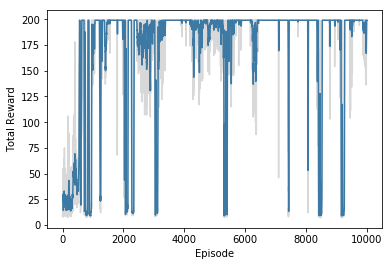

In [12]:
# Evaluation
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')